# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

# Project: Weather station

# Introduction et objectif

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris?

<img alt="weather" src="images/map.png" width=400>

### Dataset

<img alt="weather" src="images/annual_temperature.png" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

<Axes: xlabel='time'>

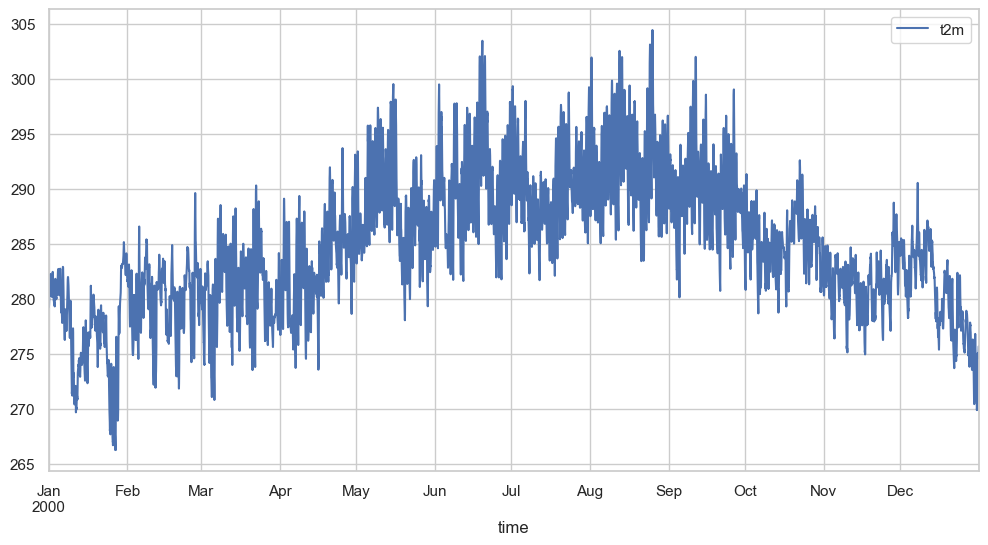

In [78]:
from pathlib import Path
import pandas as pd
import xarray as xr


import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

dir0 = Path('weather_data/paris/')
file_t2m = 't2m.nc'

ds = xr.open_dataset(Path(dir0, file_t2m))

# convert to pandas dataframe
df = ds.to_dataframe()

# remove latitude and longitude indices
df = df.droplevel([1,2])

df.loc['2000'].plot()

# Chargement et exploration du jeu de données

## Chargement des données

### Bibliothèques

In [79]:
# Imports des librairies standards
import sys
import os
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# Imports pour le Machine Learning (Scikit-Learn)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import RidgeCV


# Configuration de l'affichage
%matplotlib inline
sns.set_theme(style="whitegrid") 
plt.rcParams['figure.figsize'] = (12, 6) 

### Données

Nous chargeons les données et nous les plaçons dans un dataframe df_all

In [80]:
base_dir = Path('weather_data') 
CITIES = ['paris', 'brest', 'london', 'marseille', 'berlin']
VARIABLES = ['t2m', 'skt', 'd2m', 'u10', 'v10', 'tcc', 'sp', 'tp', 'ssrd', 'blh'] 


def load_city_var(city: str, var: str = "t2m") -> pd.DataFrame:
    city_dir = base_dir / city
    file_path = city_dir / f"{var}.nc"
    
    ds = xr.open_dataset(file_path)
    
    # Conversion et nettoyage des indices (latitude, longitude)
    df = ds.to_dataframe()
    df = df.droplevel([1, 2])
    
    # Renommage de la colonne
    df = df[[var]].rename(columns={var: f"{var}_{city}"})
    
    return df

all_dfs = []
for city in CITIES:
    for var in VARIABLES:
            df_var = load_city_var(city, var)
            all_dfs.append(df_var)


df_all = pd.concat(all_dfs, axis=1)


Nous regardons les informations sur le jeu de données et nous nettoyons les lignes qui ne sont pas complètes

In [81]:
print(df_all.head())
print(f"Taille initiale de df_all : {df_all.shape}")
df_all.dropna(inplace=True)
print(f"Taille finale de df_all après synchronisation : {df_all.shape}")

                      t2m_paris   skt_paris   d2m_paris  u10_paris  v10_paris  \
time                                                                            
1980-01-01 00:00:00  273.624573  271.886169  272.332703   1.821228   0.593918   
1980-01-01 01:00:00  273.590820  271.277069  272.302704   1.522354   0.792664   
1980-01-01 02:00:00  273.077484  271.015686  272.056641   1.478912   0.811569   
1980-01-01 03:00:00  272.647949  270.778687  271.807556   1.310043   0.710587   
1980-01-01 04:00:00  272.320129  269.853119  271.532471   1.426117   0.915924   

                     tcc_paris       sp_paris  tp_paris  ssrd_paris  \
time                                                                  
1980-01-01 00:00:00   1.000000  100071.015625       NaN         NaN   
1980-01-01 01:00:00   0.986572  100026.843750       NaN         NaN   
1980-01-01 02:00:00   1.000000   99995.453125       NaN         NaN   
1980-01-01 03:00:00   0.989990   99981.320312       NaN         NaN   
1980-0

Nous créons un dataframe contenant uniquement les températures à 2m t2m pour chaque ville

In [82]:
df_t2m = df_all.filter(regex='t2m_')
print(df_t2m.head())
print(f"Taille initiale de df_t2m : {df_t2m.shape}")
df_t2m.dropna(inplace=True)
print(f"Taille finale de df_t2m après synchronisation : {df_t2m.shape}")

                      t2m_paris   t2m_brest  t2m_london  t2m_marseille  \
time                                                                     
1980-01-01 07:00:00  272.039154  278.041107  270.650482     277.095795   
1980-01-01 08:00:00  272.022308  278.133636  270.973480     277.131683   
1980-01-01 09:00:00  271.751892  278.097595  271.242126     277.253845   
1980-01-01 10:00:00  274.506470  278.674438  272.447876     278.912720   
1980-01-01 11:00:00  275.079346  278.856689  272.575439     278.811768   

                     t2m_berlin  
time                             
1980-01-01 07:00:00  273.943451  
1980-01-01 08:00:00  273.512543  
1980-01-01 09:00:00  273.662048  
1980-01-01 10:00:00  274.168579  
1980-01-01 11:00:00  273.964111  
Taille initiale de df_t2m : (350633, 5)
Taille finale de df_t2m après synchronisation : (350633, 5)


# Premières observations

Nous commençons par observer l'ensemble des données et réaliser des statistiques descriptives.

### Statistiques générales

In [83]:
# Affichage de toutes les statistiques descriptives
df_all_description = df_all.describe().T

ordered_cols = []
for var in VARIABLES:
    for city in CITIES:
        ordered_cols.append(f'{var}_{city}')

df_description_ordered = df_all_description.loc[ordered_cols]
print(df_description_ordered)

                   count           mean            std           min  \
t2m_paris       350633.0     284.364105       7.123415    256.771332   
t2m_brest       350633.0     285.042236       4.206890    266.545654   
t2m_london      350633.0     283.669922       5.922341    257.483673   
t2m_marseille   350633.0     288.001648       6.454107    266.325012   
t2m_berlin      350633.0     282.741394       8.276489    251.373947   
skt_paris       350633.0     284.298798       7.725009    252.089996   
skt_brest       350633.0     285.286835       4.394971    268.572327   
skt_london      350633.0     283.487030       6.611135    253.604446   
skt_marseille   350633.0     288.421844       6.689270    269.696289   
skt_berlin      350633.0     282.763336       8.779633    248.752258   
d2m_paris       350633.0     280.450897       5.701001    254.678604   
d2m_brest       350633.0     281.943237       4.549535    256.819458   
d2m_london      350633.0     280.181183       5.071845    256.20

D'après le tableau ci-dessus, on peut faire quelques observations pour chaque variable :

- $\texttt{t2m}$ (Température à 2 mètres, K)
    - Moyenne : Varie de $\texttt{t2m\_berlin}$ ($282.74$ K) à $\texttt{t2m\_marseille}$ ($288.00$ K). Marseille est la ville la plus chaude en moyenne.
    - Variabilité ($\sigma$) : $\texttt{t2m\_berlin}$ ($8.28$ K) et $\texttt{t2m\_paris}$ ($7.12$ K) montrent le plus grand écart-type. $\texttt{t2m\_brest}$ ($4.21$ K) est la plus stable (climat océanique?)

- $\texttt{skt}$ (Température de la peau, K)
    - Les statistiques sont très proches de $\texttt{t2m}$ pour toutes les villes

- $\texttt{d2m}$ (Point de rosée à 2m, K)
    - Toujours inférieur à $\texttt{t2m}$

- $\texttt{u10}$ et $\texttt{v10}$ (Composantes du vent (nord/sud et est/ouest) à 10m, $m/s$)
    - Moyenne : Proche de zéro pour toutes les villes (pas de direction dominante).
    - Variabilité ($\sigma$) : Les vents sont les plus variables à $\texttt{u10\_brest}$ ($\approx 4.2$ $m/s$) et $\texttt{u10\_marseille}$ ($\approx 4.0$ $m/s$),

- $\texttt{tcc}$ (Couverture nuageuse totale, compris dans $0-1$)
    - Moyenne : $\texttt{tcc\_marseille}$ est la plus faible ($\approx 0.43$). Les autres villes sont majoritairement couvertes (moyennes $\approx 0.66$ à $0.69$).

- $\texttt{sp}$ (Pression de surface, Pa)
    - Moyenne : Toutes les villes sont proches de $100 000$ Pa.
    - Variabilité ($\sigma$) : L'écart-type est très faible ($\approx 1000$ Pa), une grande stabilité de la pression

- $\texttt{tp}$ (Précipitations totales, m)
    - Moyenne : Très faible ($\approx 10^{-4}$ $m/h$). $\texttt{tp\_brest}$ est la plus élevée.

- $\texttt{ssrd}$ (Rayonnement solaire, $J/m^2$)
    - Moyenne : $\texttt{ssrd\_marseille}$ reçoit le plus de rayonnement solaire ($676622$ $J/m^2$).

- $\texttt{blh}$ (Hauteur de la couche limite, m)
    - Moyenne : Varie de $505$ m (Marseille) à $668$ m (Brest).
    - Variabilité : $\texttt{blh\_berlin}$ ($491.53$ m) et $\texttt{blh\_paris}$ ($470.67$ m) ont la plus grande variabilité.

### Corrélations

Avant de construire nos modèles prédictifs, il est essentiel d'évaluer la pertinence de nos prédicteurs. Nous allons ici analyser la **matrice de corrélation** pour quantifier la dépendance linéaire entre la météo à Paris et celle des villes voisines.

Une forte corrélation validera notre hypothèse selon laquelle l'information contenue dans les stations environnantes (Berlin, Londres, etc.) permet d'inférer l'état de la station parisienne. 

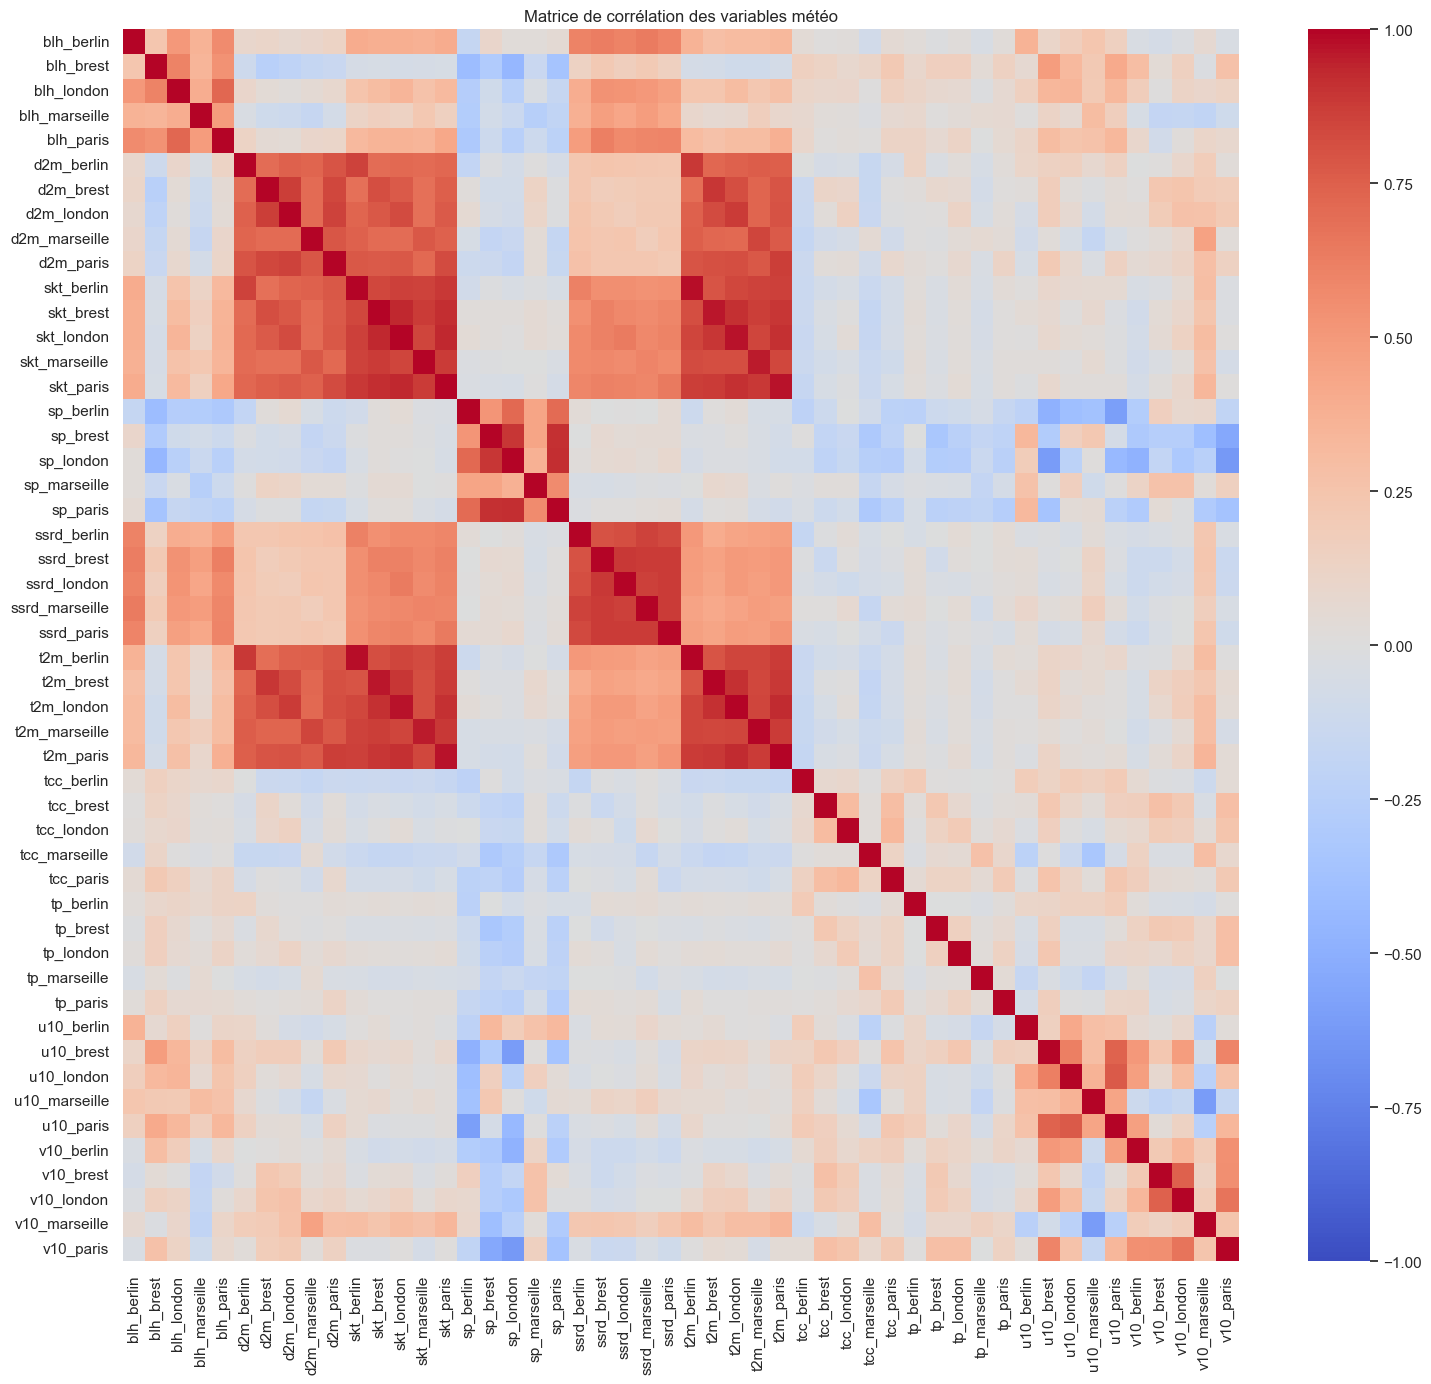

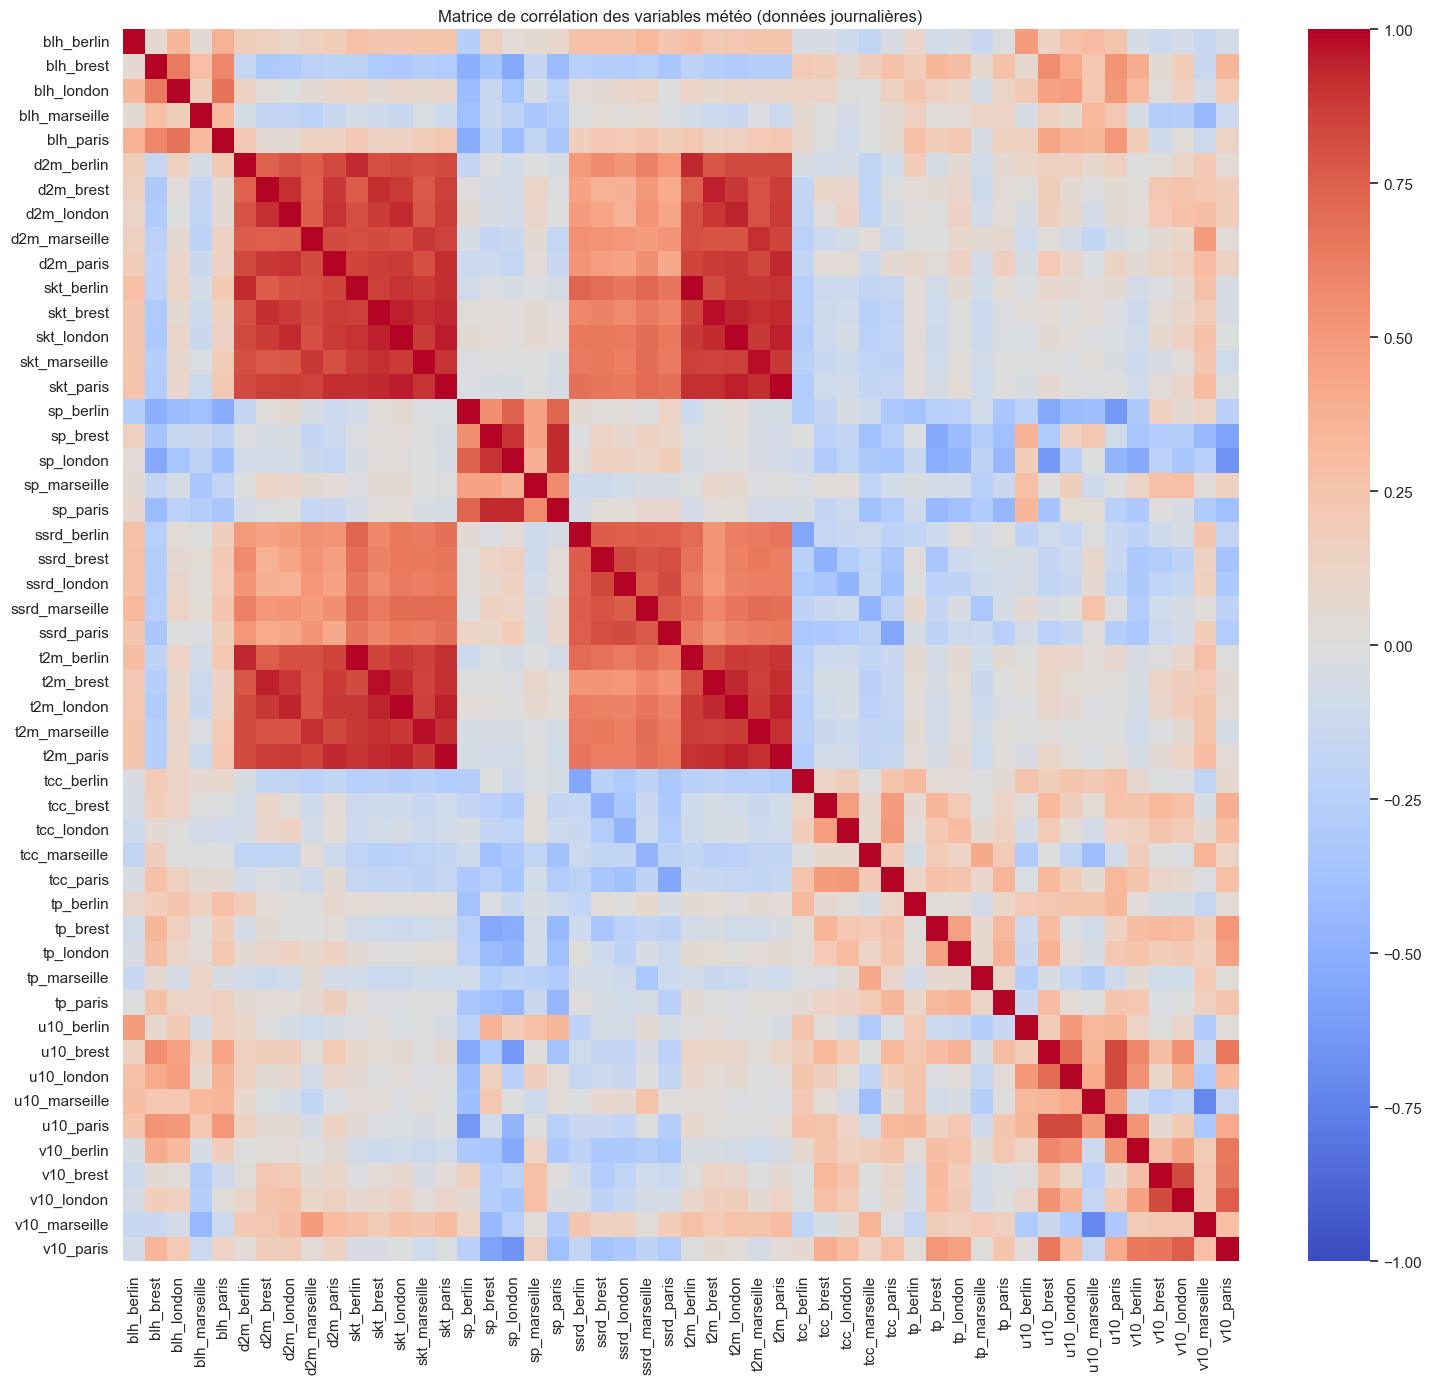

In [84]:
corr_matrix = df_all.corr()
sorted_cols = sorted(df_all.columns)
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix.loc[sorted_cols, sorted_cols], cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation des variables météo")
plt.show()

#On trace également les correlations pour les variables rééchantillonées en données journalières
df_all_daily = df_all.resample('D').mean()
corr_matrix_daily = df_all_daily.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix_daily.loc[sorted_cols, sorted_cols], cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation des variables météo (données journalières)")
plt.show()

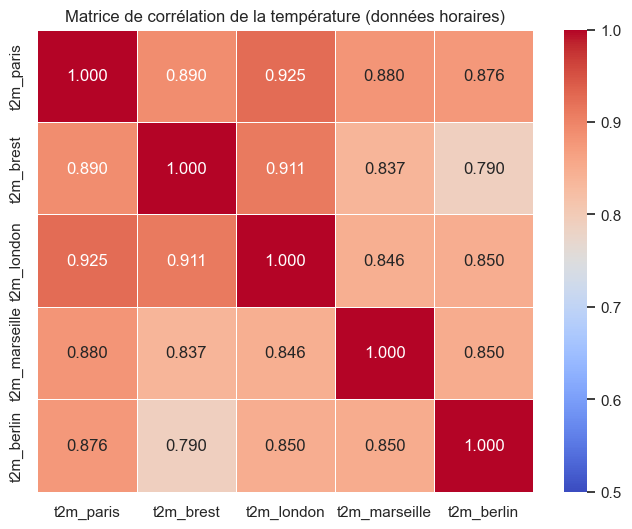

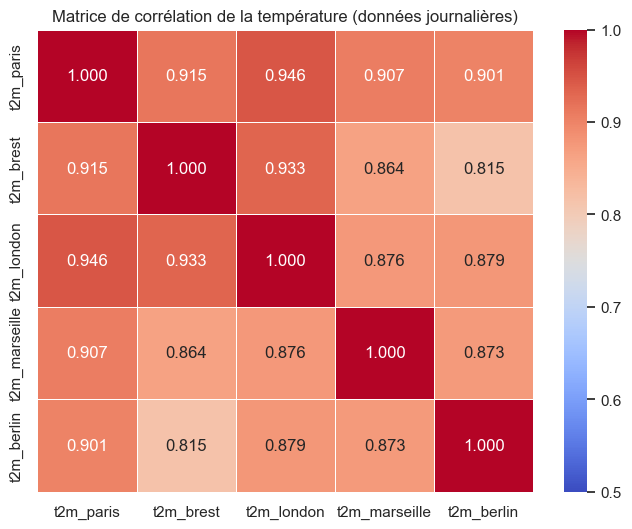

In [85]:
# rééchantillonage de la matrice df_t2m en données journalières
df_t2m_daily = df_t2m.resample('D').mean()

#On va tracer les correlations entre les différentes villes pour la variable t2m uniquement, avec les données rééchantillonnées en données horaires et les données brutes
corr_matrix_t2m = df_t2m.corr()
corr_matrix_t2m_daily = df_t2m_daily.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_t2m, annot=True, cmap='coolwarm', fmt=".3f",vmin=0.5, vmax=1,linewidths=.5)
plt.title("Matrice de corrélation de la température (données horaires)")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_t2m_daily, annot=True, cmap='coolwarm', fmt=".3f",vmin=0.5, vmax=1,linewidths=.5)
plt.title("Matrice de corrélation de la température (données journalières)")
plt.show()


Le rééchantillonage en données journalières a pour effet d'augmenter les correlations fortes. Les corrélations déja fortes deviennent encore plus fortes.

La température à Paris est fortement corrélée à celle des autres villes (Londres en particulier), nous devrions pouvoir la reconstruire à partir de ces données. Nous traçons les températures de plusieurs villes sur une année, pour observer.

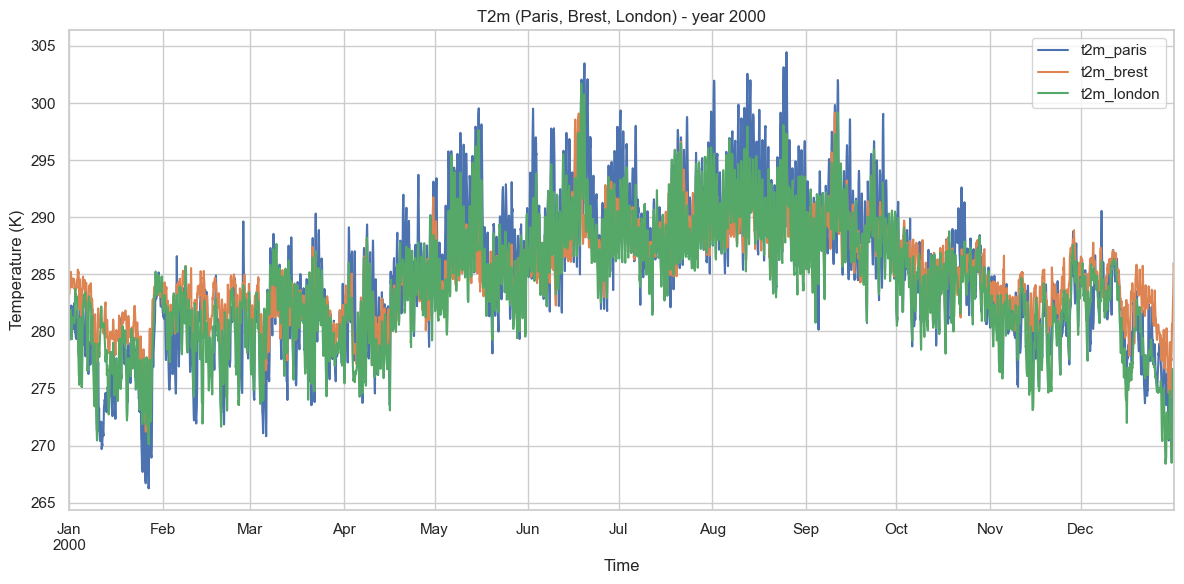

In [86]:
# On prend par exemple l'année 2000 pour ne pas avoir un plot énorme
df_2000 = df_t2m["2000-01-01":"2000-12-31"]

ax = df_2000[["t2m_paris", "t2m_brest", "t2m_london"]].plot()
ax.set_title("T2m (Paris, Brest, London) - year 2000")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (K)")
plt.tight_layout()
plt.show()


Sur l'année 2000, on observe bien que les températures dans les trois villes ont des tendances similaires

# Premier modèle simple : régression linéaire

Pour initier notre démarche de reconstruction, nous nous concentrons sur la variable météorologique la plus intuitive et souvent la plus corrélée spatialement : la température à 2 mètres (`t2m`).

Nous allons entraîner un modèle de **régression linéaire** en utilisant comme uniques variables explicatives les températures relevées simultanément dans les stations voisines (Brest, Londres, Marseille, Berlin). Ce modèle nous permettra de quantifier la capacité des stations "voisines" à expliquer la variance de la température parisienne sans autre information temporelle ou physique complexe.

Nous séparons les données en un ensemble d'entraînement (avant 2010) et un ensemble de test (après 2010). Nous évaluons la performance du modèle à l'aide de l'erreur quadratique moyenne (RMSE) sur les données horaires et journalières.

RMSE sur l'ensemble du test (après 2010-01-01): 2.287 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.8992
        Variable     Coeff
0      t2m_brest  0.310591
1     t2m_london  0.491277
2  t2m_marseille  0.219218
3     t2m_berlin  0.187665


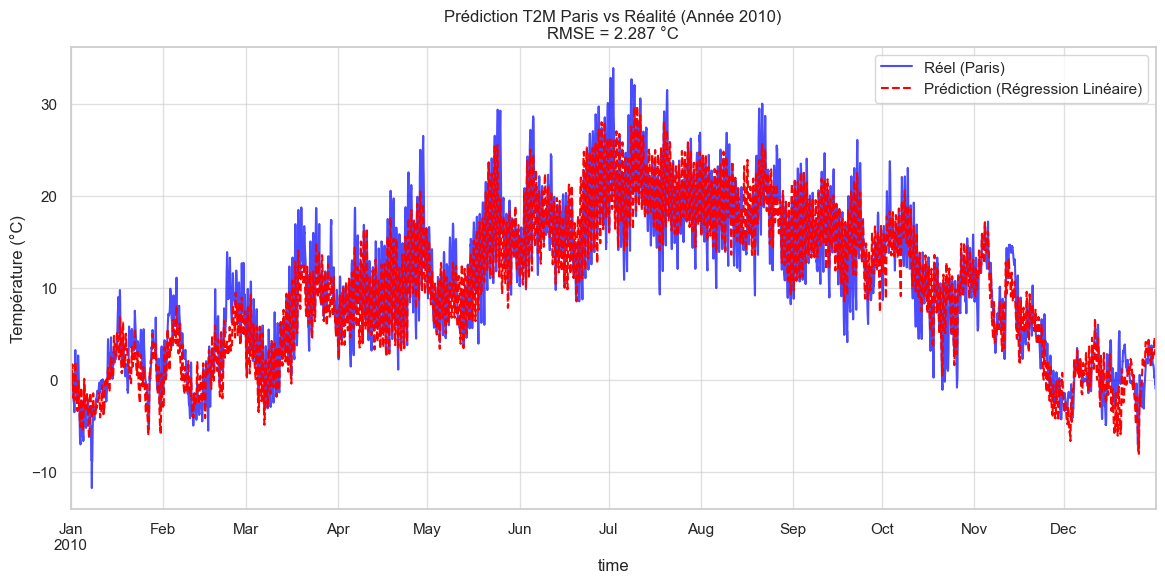

In [87]:
target_col = "t2m_paris"
feature_cols = [c for c in df_t2m.columns if c != target_col] 

X = df_t2m[feature_cols]
y = df_t2m[target_col]

split_date = "2010-01-01"

# Entraînement avant 2010
X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

# Test à partir de 2010
X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred_series = pd.Series(model.predict(X_test), index=y_test.index)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
print(df_coef)

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']


y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité (Année 2010)\nRMSE = {rmse_test:.3f} °C")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


RMSE sur l'ensemble du test (après2010-01-01): 1.746 K / °C
R² sur l'ensemble du test (après2010-01-01): 0.9280
        Variable     Coeff
0      t2m_brest  0.314446
1     t2m_london  0.487472
2  t2m_marseille  0.211600
3     t2m_berlin  0.184211


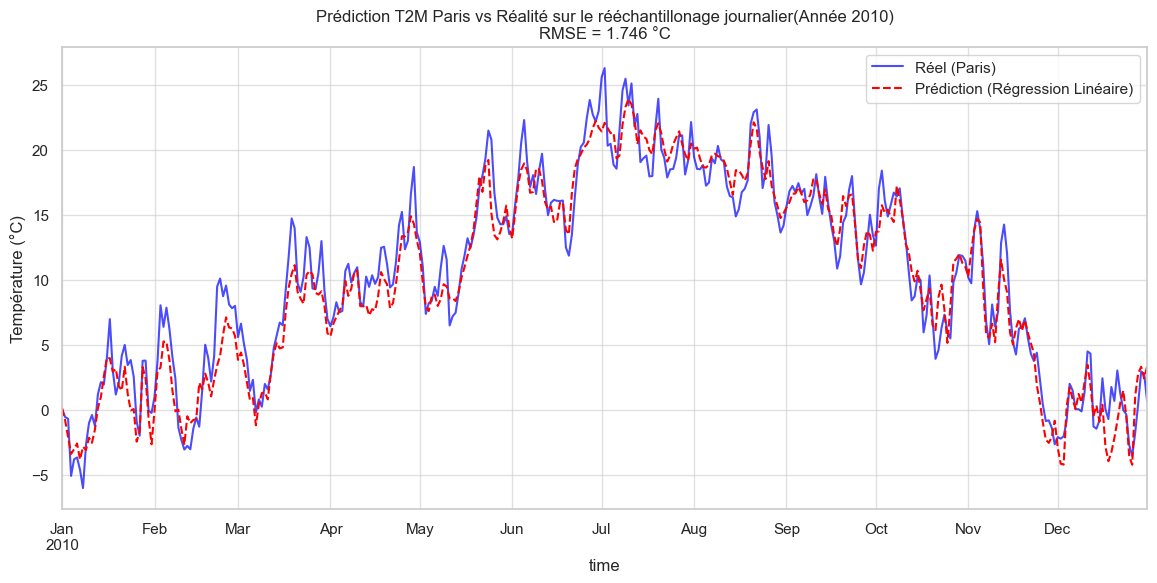

In [88]:
target_col = "t2m_paris"
feature_cols = [c for c in df_t2m_daily.columns if c != target_col] 

X = df_t2m_daily[feature_cols]
y = df_t2m_daily[target_col]

split_date = "2010-01-01"

# Entraînement avant 2010
X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

# Test à partir de 2010
X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred_series = pd.Series(model.predict(X_test),index=y_test.index)


rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après{split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après{split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
print(df_coef)

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']


y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité sur le rééchantillonage journalier(Année 2010)\nRMSE = {rmse_test:.3f} °C")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


Le modèle reproduit bien les tendances avec un R² proche de 1. Nous sommes plus précis sur les données rééchantillonnées.

## Ajout de davantage de features

Pour améliorer la précision de notre modèle, nous allons utiliser **l'ensemble des variables disponibles** des stations voisines (vent, pression, humidité, etc.) et non plus seulement leur température. L'hypothèse est que des phénomènes comme le vent ou la pression à Londres peuvent être des précurseurs de la température à Paris.

Cependant, ces variables physiques ont des ordres de grandeur très hétérogènes (ex: une pression atmosphérique en Pascals est ~100 000 fois plus grande qu'une couverture nuageuse comprise entre 0 et 1). Pour que la régression linéaire puisse converger correctement et ne soit pas biaisée par ces différences d'échelle, nous appliquons une **normalisation** pour ramener toutes les variables à une moyenne nulle et un écart-type de 1.

RMSE sur l'ensemble du test (après 2010-01-01): 2.116 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.9137
          Variable     Coeff
10      t2m_london  3.039351
0        t2m_brest  2.337472
20   t2m_marseille  2.312402
30      t2m_berlin  1.911922
1        skt_brest -1.115848
21   skt_marseille -1.029282
32      d2m_berlin -0.669323
28  ssrd_marseille  0.643684
12      d2m_london -0.521872
3        u10_brest  0.412709
14      v10_london -0.372872
36       sp_berlin -0.332052
24   v10_marseille  0.315165
11      skt_london  0.302761
34      v10_berlin -0.282631
29   blh_marseille -0.253927
19      blh_london -0.217761
33      u10_berlin -0.203706
8       ssrd_brest  0.187753
26    sp_marseille  0.176392
23   u10_marseille -0.167108
2        d2m_brest  0.166311
15      tcc_london -0.161004
38     ssrd_berlin -0.149672
6         sp_brest -0.149469
18     ssrd_london -0.112920
5        tcc_brest  0.109284
35      tcc_berlin -0.106474
16       sp_london -0.101659
9        blh_bre

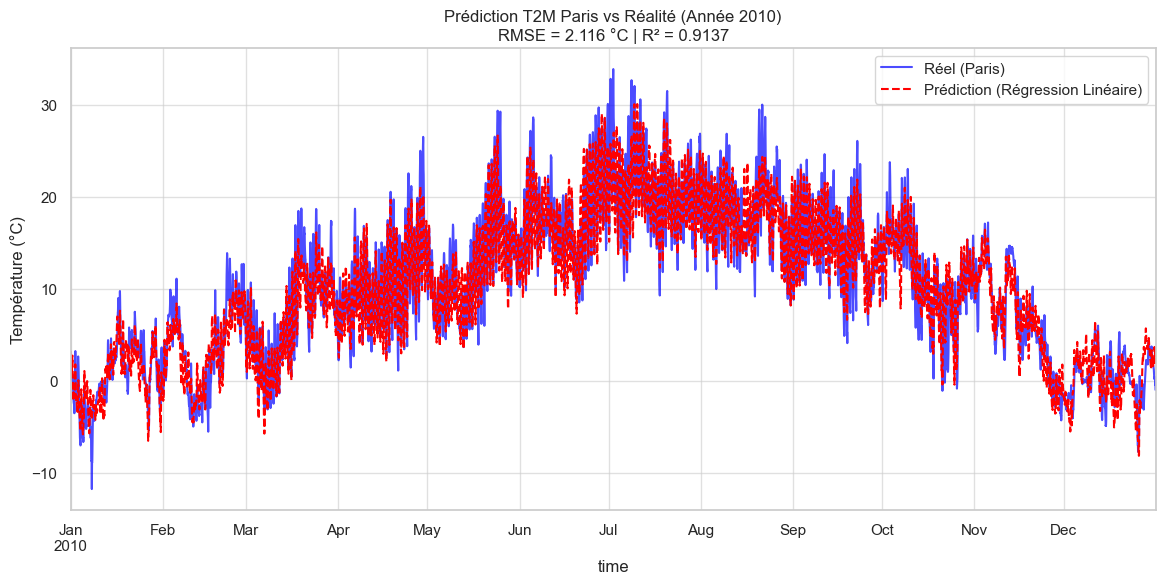

In [89]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]

X = df_all[feature_cols]
y = df_all[target_col]

split_date = "2010-01-01"

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_series = pd.Series(model.predict(X_test_scaled), index=y_test.index)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
df_coef['Abs_Coeff'] = df_coef['Coeff'].abs()
df_coef = df_coef.sort_values(by='Abs_Coeff', ascending=False)
print(df_coef.drop(columns=['Abs_Coeff']))

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']

y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité (Année 2010)\nRMSE = {rmse_test:.3f} °C | R² = {r2_test:.4f}")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

RMSE sur l'ensemble du test (après 2010-01-01): 1.560 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.9426
          Variable     Coeff
10      t2m_london  3.402906
30      t2m_berlin  2.740114
20   t2m_marseille  1.842374
0        t2m_brest  1.545558
31      skt_berlin -1.542935
21   skt_marseille -1.064772
6         sp_brest -0.855172
16       sp_london  0.805418
3        u10_brest  0.652963
28  ssrd_marseille  0.639094
11      skt_london -0.567065
14      v10_london -0.523628
32      d2m_berlin -0.447830
36       sp_berlin -0.368058
22   d2m_marseille  0.353298
23   u10_marseille -0.332301
1        skt_brest -0.312824
34      v10_berlin -0.305512
2        d2m_brest  0.303212
12      d2m_london -0.296081
13      u10_london  0.293302
8       ssrd_brest -0.222285
33      u10_berlin -0.211509
29   blh_marseille -0.183240
19      blh_london -0.174357
15      tcc_london -0.172822
26    sp_marseille  0.152442
24   v10_marseille  0.131490
18     ssrd_london  0.130769
38     ssrd_berl

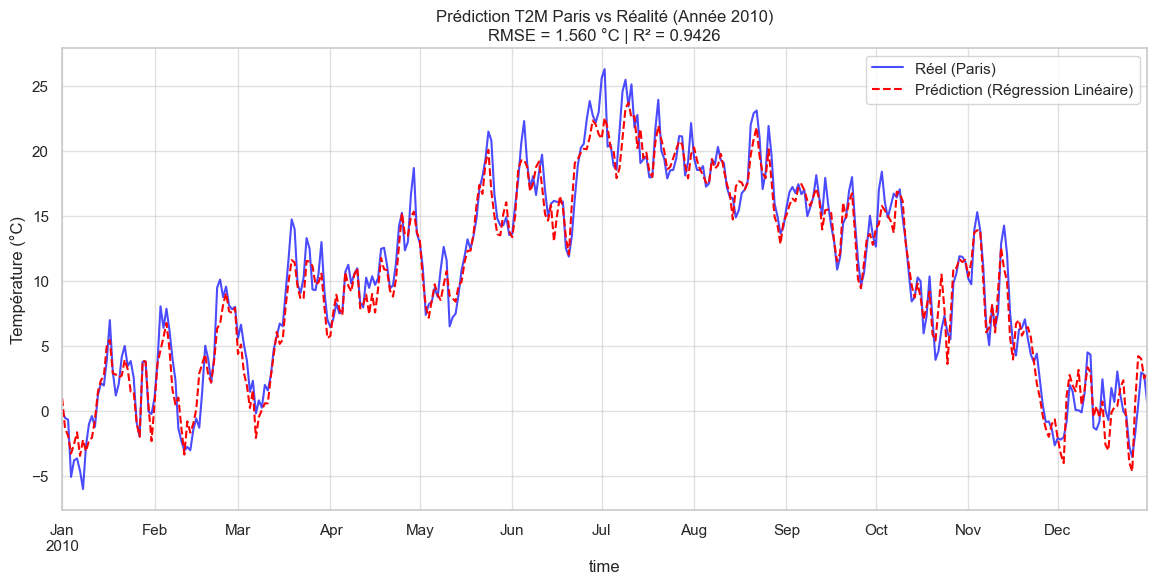

In [90]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]

X = df_all_daily[feature_cols]
y = df_all_daily[target_col]

split_date = "2010-01-01"

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_series = pd.Series(model.predict(X_test_scaled), index=y_test.index)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
df_coef['Abs_Coeff'] = df_coef['Coeff'].abs()
df_coef = df_coef.sort_values(by='Abs_Coeff', ascending=False)
print(df_coef.drop(columns=['Abs_Coeff']))

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']

y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité (Année 2010)\nRMSE = {rmse_test:.3f} °C | R² = {r2_test:.4f}")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

On voit que la température à Paris peut être prédite avec une très bonne précision à partir des autres villes (R²=0.92 sur les données horaires)
L’ajout d’autres variables météo améliore l’erreur absolue, ces paramètres apportent une information complémentaire, même si leurs coefficients sont significativement plus faibles.

La simple corrélation globale peut masquer des dynamiques temporelles importantes. Ici, nous calculons la corrélation jour par jour (moyennée sur toutes les années disponibles) pour observer comment l'influence des variables des villes voisines sur la température de Paris évolue au fil des saisons (hiver vs été).

In [91]:
import plotly.graph_objects as go

warnings.filterwarnings('ignore')
df = df_all_daily.copy()
df["dayofyear"] = df.index.dayofyear

cities = ["brest", "marseille", "london", "berlin"]
variables = ["t2m", "ssrd", "u10", "v10", "tcc", "sp", "blh"]

corrs = []
for day in range(1, 367):
    subset = df[df["dayofyear"] == day]
    if len(subset) > 10:
        corr = subset.corrwith(subset["t2m_paris"])
        corrs.append(corr)

corr_df = pd.DataFrame(corrs, index=range(1, len(corrs)+1))
corr_df.index.name = "dayofyear"

# Créer une trace par variable et par ville
fig = go.Figure()

for city in cities:
    for var in variables:
        col = f"{var}_{city}"
        if col in corr_df.columns:
            fig.add_trace(go.Scatter(
                x=corr_df.index,
                y=corr_df[col],
                mode='lines',
                name=f"{var} ({city})",
                visible=(city == "paris")  # seule Paris visible par défaut
            ))

# Menu déroulant
buttons = []
for i, city in enumerate(cities):
    visible = [False] * len(fig.data)
    for j, var in enumerate(variables):
        idx = i * len(variables) + j
        visible[idx] = True
    buttons.append(dict(
        label=city.capitalize(),
        method="update",
        args=[{"visible": visible},
              {"title": f"Corrélation moyenne avec t2m_paris – {city.capitalize()}"}]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=0.1, y=1.15
    )],
    title="Corrélation moyenne avec t2m_paris",
    xaxis_title="Jour de l'année",
    yaxis_title="Corrélation",
    hovermode="x unified"
)

fig.show()


L'analyse visuelle des corrélations met en évidence une forte variabilité saisonnière. On observe clairement que la relation entre la météo parisienne et celle des villes voisines n'est pas constante : certaines variables sont très prédictives en hiver, mais leur influence diminue en été (et inversement).

Cette instabilité suggère qu'un modèle unique serait sous-optimal, car il devrait faire un compromis moyen entre ces dynamiques opposées. Pour capturer ces spécificités, nous entrainerons des modèles distincts pour chaque mois de l'année.

# PCA

Notre jeu de données comporte un grand nombre de variables explicatives (plusieurs paramètres physiques pour chaque ville voisine). Comme nous l'avons vu avec la matrice de corrélation, beaucoup de ces variables sont fortement liées entre elles

L'objectif de cette section est d'appliquer une PCA pour projeter nos données sur un nombre réduit de composantes principales. Nous chercherons à voir si un modèle entraîné sur ces composantes peut atteindre une précision équivalente tout en étant plus compact.

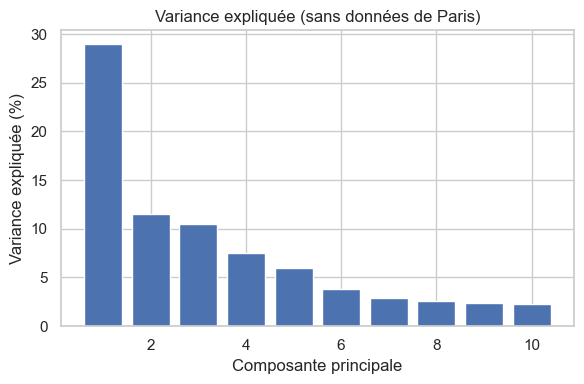

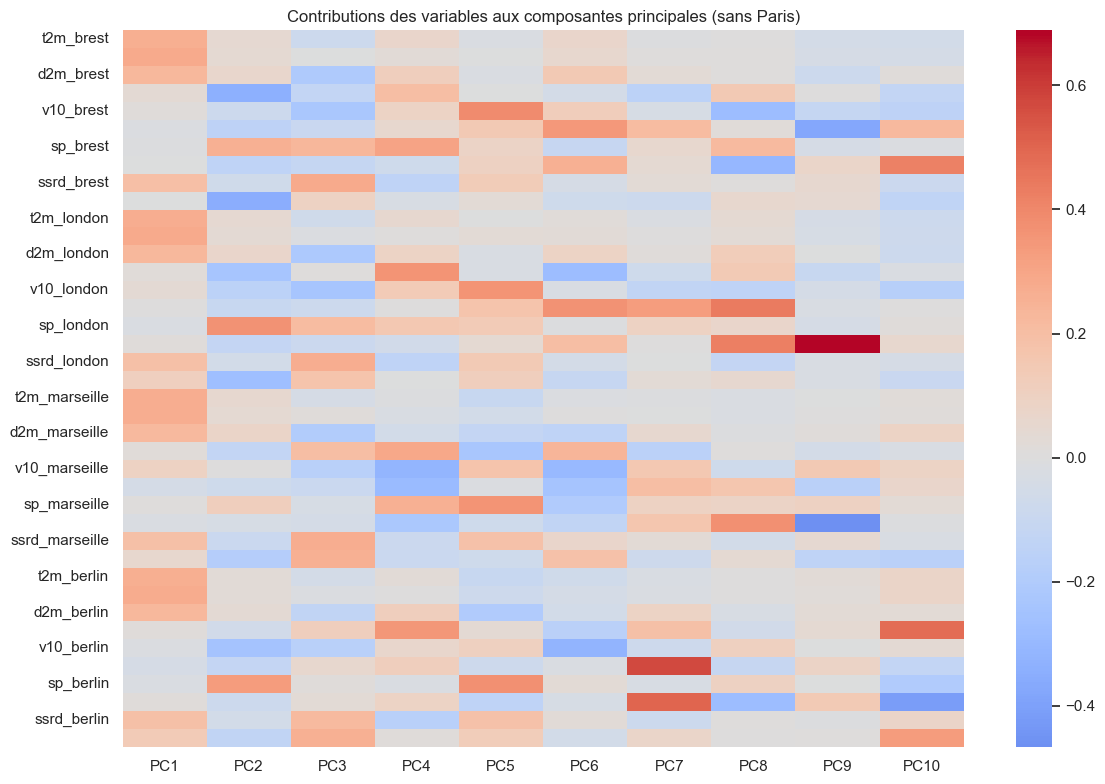

In [92]:
X = df_all.loc[:, ~df_all.columns.str.endswith("_paris")].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


n_components = 10
pca = PCA(n_components)
Z = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(Z, index=X.index, columns=[f"PC{i+1}" for i in range(pca.n_components_)])


plt.figure(figsize=(6,4))
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée (sans données de Paris)")
plt.grid(True)
plt.tight_layout()
plt.show()


loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

plt.figure(figsize=(12,8))
sns.heatmap(loadings, cmap="coolwarm", center=0)
plt.title("Contributions des variables aux composantes principales (sans Paris)")
plt.tight_layout()
plt.show()


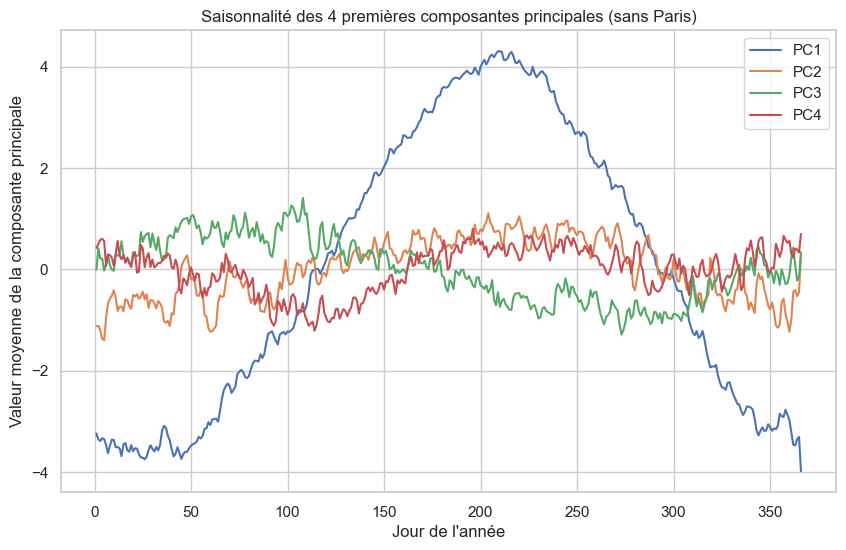

In [93]:
plt.figure(figsize=(10,6))
df_pca["dayofyear"] = df_pca.index.dayofyear
df_pca.groupby("dayofyear")["PC1"].mean().plot()
df_pca.groupby("dayofyear")["PC2"].mean().plot()
df_pca.groupby("dayofyear")["PC3"].mean().plot()
df_pca.groupby("dayofyear")["PC4"].mean().plot()
plt.xlabel("Jour de l'année")
plt.ylabel("Valeur moyenne de la composante principale")
plt.title("Saisonnalité des 4 premières composantes principales (sans Paris)")
plt.legend(["PC1", "PC2", "PC3", "PC4"])
plt.show()



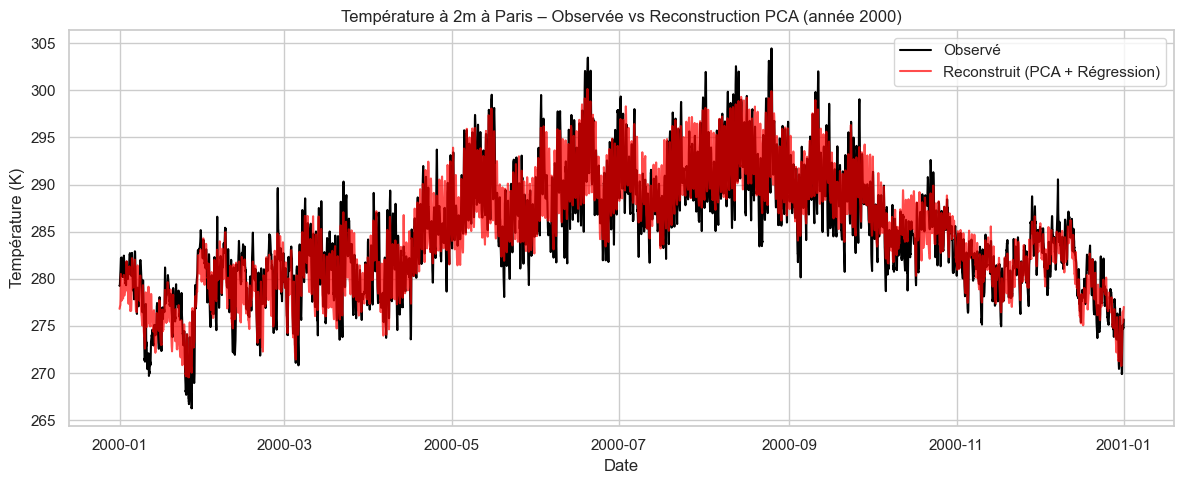

R² global : 0.887
RMSE global : 2.390 K


In [94]:
# Données d'entrée : on prend quelques composantes principales
X_pca = df_pca[["PC1", "PC2", "PC3", "PC4","PC5","PC6"]]
y = df_all["t2m_paris"].loc[X_pca.index]  # s'assure que les index correspondent

# Entraînement du modèle linéaire
model = LinearRegression()
model.fit(X_pca, y)
y_pred = model.predict(X_pca)

# On met les prédictions dans un Df
df_pred = pd.DataFrame({
    "t2m_paris_real": y,
    "t2m_paris_pred": y_pred
}, index=X_pca.index)

df_2000 = df_pred["2000-01-01":"2000-12-31"]

plt.figure(figsize=(12,5))
plt.plot(df_2000.index, df_2000["t2m_paris_real"], label="Observé", color="black", linewidth=1.5)
plt.plot(df_2000.index, df_2000["t2m_paris_pred"], label="Reconstruit (PCA + Régression)", color="red", alpha=0.7)
plt.title("Température à 2m à Paris – Observée vs Reconstruction PCA (année 2000)")
plt.xlabel("Date")
plt.ylabel("Température (K)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

r2 = r2_score(y, y_pred)
print(f"R² global : {r2:.3f}")
rmse = mean_squared_error(y, y_pred) ** 0.5  # √MSE
print(f"RMSE global : {rmse:.3f} K")



La PCA affiche des performances légèrement inférieures à celles de la régression linéaire sur les variables brutes.

La PCA construit ses composantes en cherchant à maximiser la variance des variables explicatives uniquement, sans tenir compte de la cible. Il est probable que certaines dimensions de faible variance contenaient une information utile pour la prédiction spécifique de la température à Paris. 

# Ridge

Les variables météorologiques des villes voisines sont fortement corrélées entre elles. Une régression linéaire standard peut devenir instable et accorder trop d'importance à certaines variables, risquant le sur-apprentissage.

Pour palllier ce problème, nous utilisons une régression Ridge. Cette méthode contraint les coefficients du modèle à rester petits. La difficulté réside dans le choix de l'hyperparamètre de complexité $\alpha$.

Nous déterminons le meilleur $\alpha$ par CV Temporelle (`TimeSeriesSplit`) sur le jeu d'entraînement, afin de respecter la chronologie des données.

Meilleur Alpha trouvé : 206.9138 (R² validé : 0.9154)


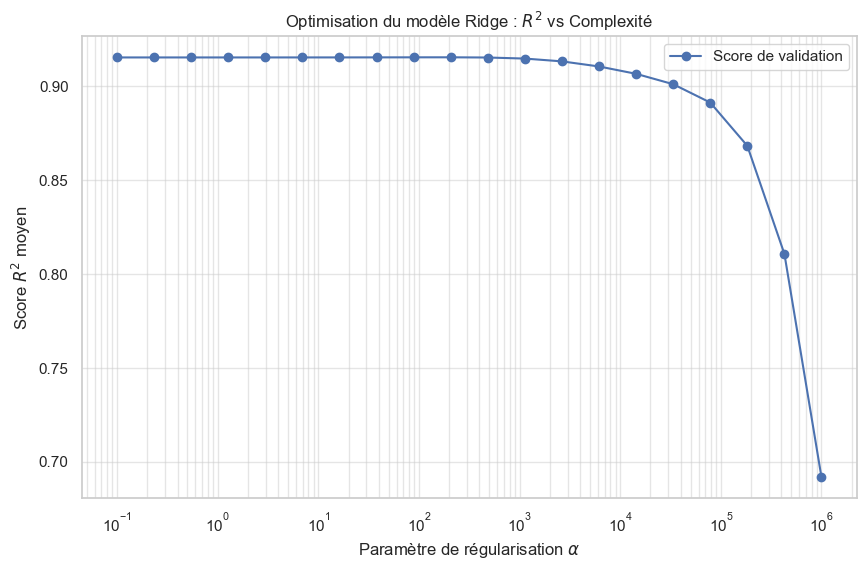

In [95]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]

X = df_all[feature_cols]
y = df_all[target_col]

split_date = "2010-01-01"

X_cv = X.loc[X.index < split_date]
y_cv = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

#Scaling
scaler = StandardScaler()
X_cv_scaled = scaler.fit_transform(X_cv)
X_test_scaled = scaler.transform(X_test)



# 1. Espace recherche alpha
alphas = np.logspace(-1, 6, 20)

# 2. Configuration de la cv
cv_split = TimeSeriesSplit(n_splits=5)

# 3. Boucle de recherche du meilleur alpha
r2_scores = []

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    # Calcul du score moyen sur les différents splits temporels
    scores = cross_val_score(reg, X_cv_scaled, y_cv, cv=cv_split, scoring='r2')
    r2_scores.append(scores.mean())

# 4. Identification du meilleur modèle
best_idx = np.argmax(r2_scores)
best_alpha = alphas[best_idx]
best_r2 = r2_scores[best_idx]

print(f"Meilleur Alpha trouvé : {best_alpha:.4f} (R² validé : {best_r2:.4f})")

plt.figure(figsize=(10, 6))
plt.plot(alphas, r2_scores, marker='o', label='Score de validation')
plt.xscale('log')
plt.xlabel(r'Paramètre de régularisation $\alpha$')
plt.ylabel(r'Score $R^2$ moyen')
plt.title(r'Optimisation du modèle Ridge : $R^2$ vs Complexité')
plt.legend()
plt.grid(True, which="both", alpha=0.5)
plt.show()

alpha=206.91
RMSE Test : 2.110 °C
R² Test   : 0.9142


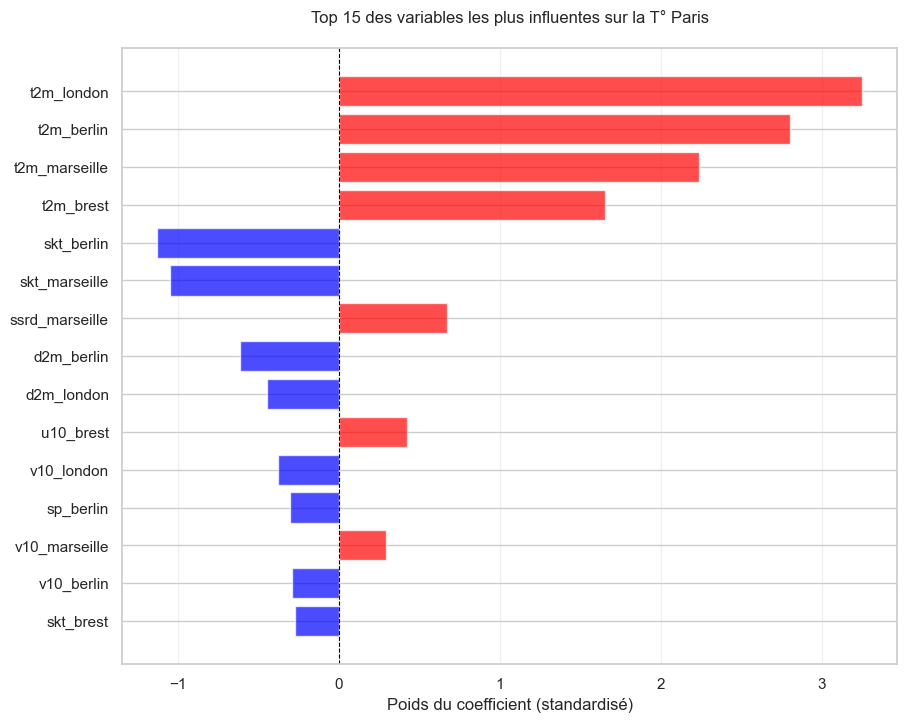

In [96]:
# Entraînement final avec le meilleur alpha trouvé précédemment
final_model = Ridge(alpha=best_alpha) 
final_model.fit(X_cv_scaled, y_cv)

# Prédiction et évaluation sur l'ensemble de test
y_pred = final_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_final = r2_score(y_test, y_pred)

print(f"alpha={best_alpha:.2f}")
print(f"RMSE Test : {rmse:.3f} °C")
print(f"R² Test   : {r2_final:.4f}")


# Création du DataFrame des coefficients
df_coef = pd.DataFrame({'Variable': feature_cols, 'Coeff': final_model.coef_})
df_coef['Abs_Coeff'] = df_coef['Coeff'].abs()

# Sélection des 15 variables les plus influentes
top_n = 15
df_plot = df_coef.sort_values(by='Abs_Coeff', ascending=True).tail(top_n)

colors = ['red' if c > 0 else 'blue' for c in df_plot['Coeff']]

plt.figure(figsize=(10, 8))
bars = plt.barh(df_plot['Variable'], df_plot['Coeff'], color=colors, alpha=0.7)
plt.xlabel("Poids du coefficient (standardisé)")
plt.title(f"Top {top_n} des variables les plus influentes sur la T° Paris\n")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

Comme observé lors de l'analyse exploratoire, les corrélations évoluent au fil de l'année. Un modèle unique "moyen" masque ces spécificités.

Nous allons ici entraîner 12 modèles Ridge distincts (un par mois). Cette stratégie permet d'adapter les coefficients aux dynamiques de chaque saison.

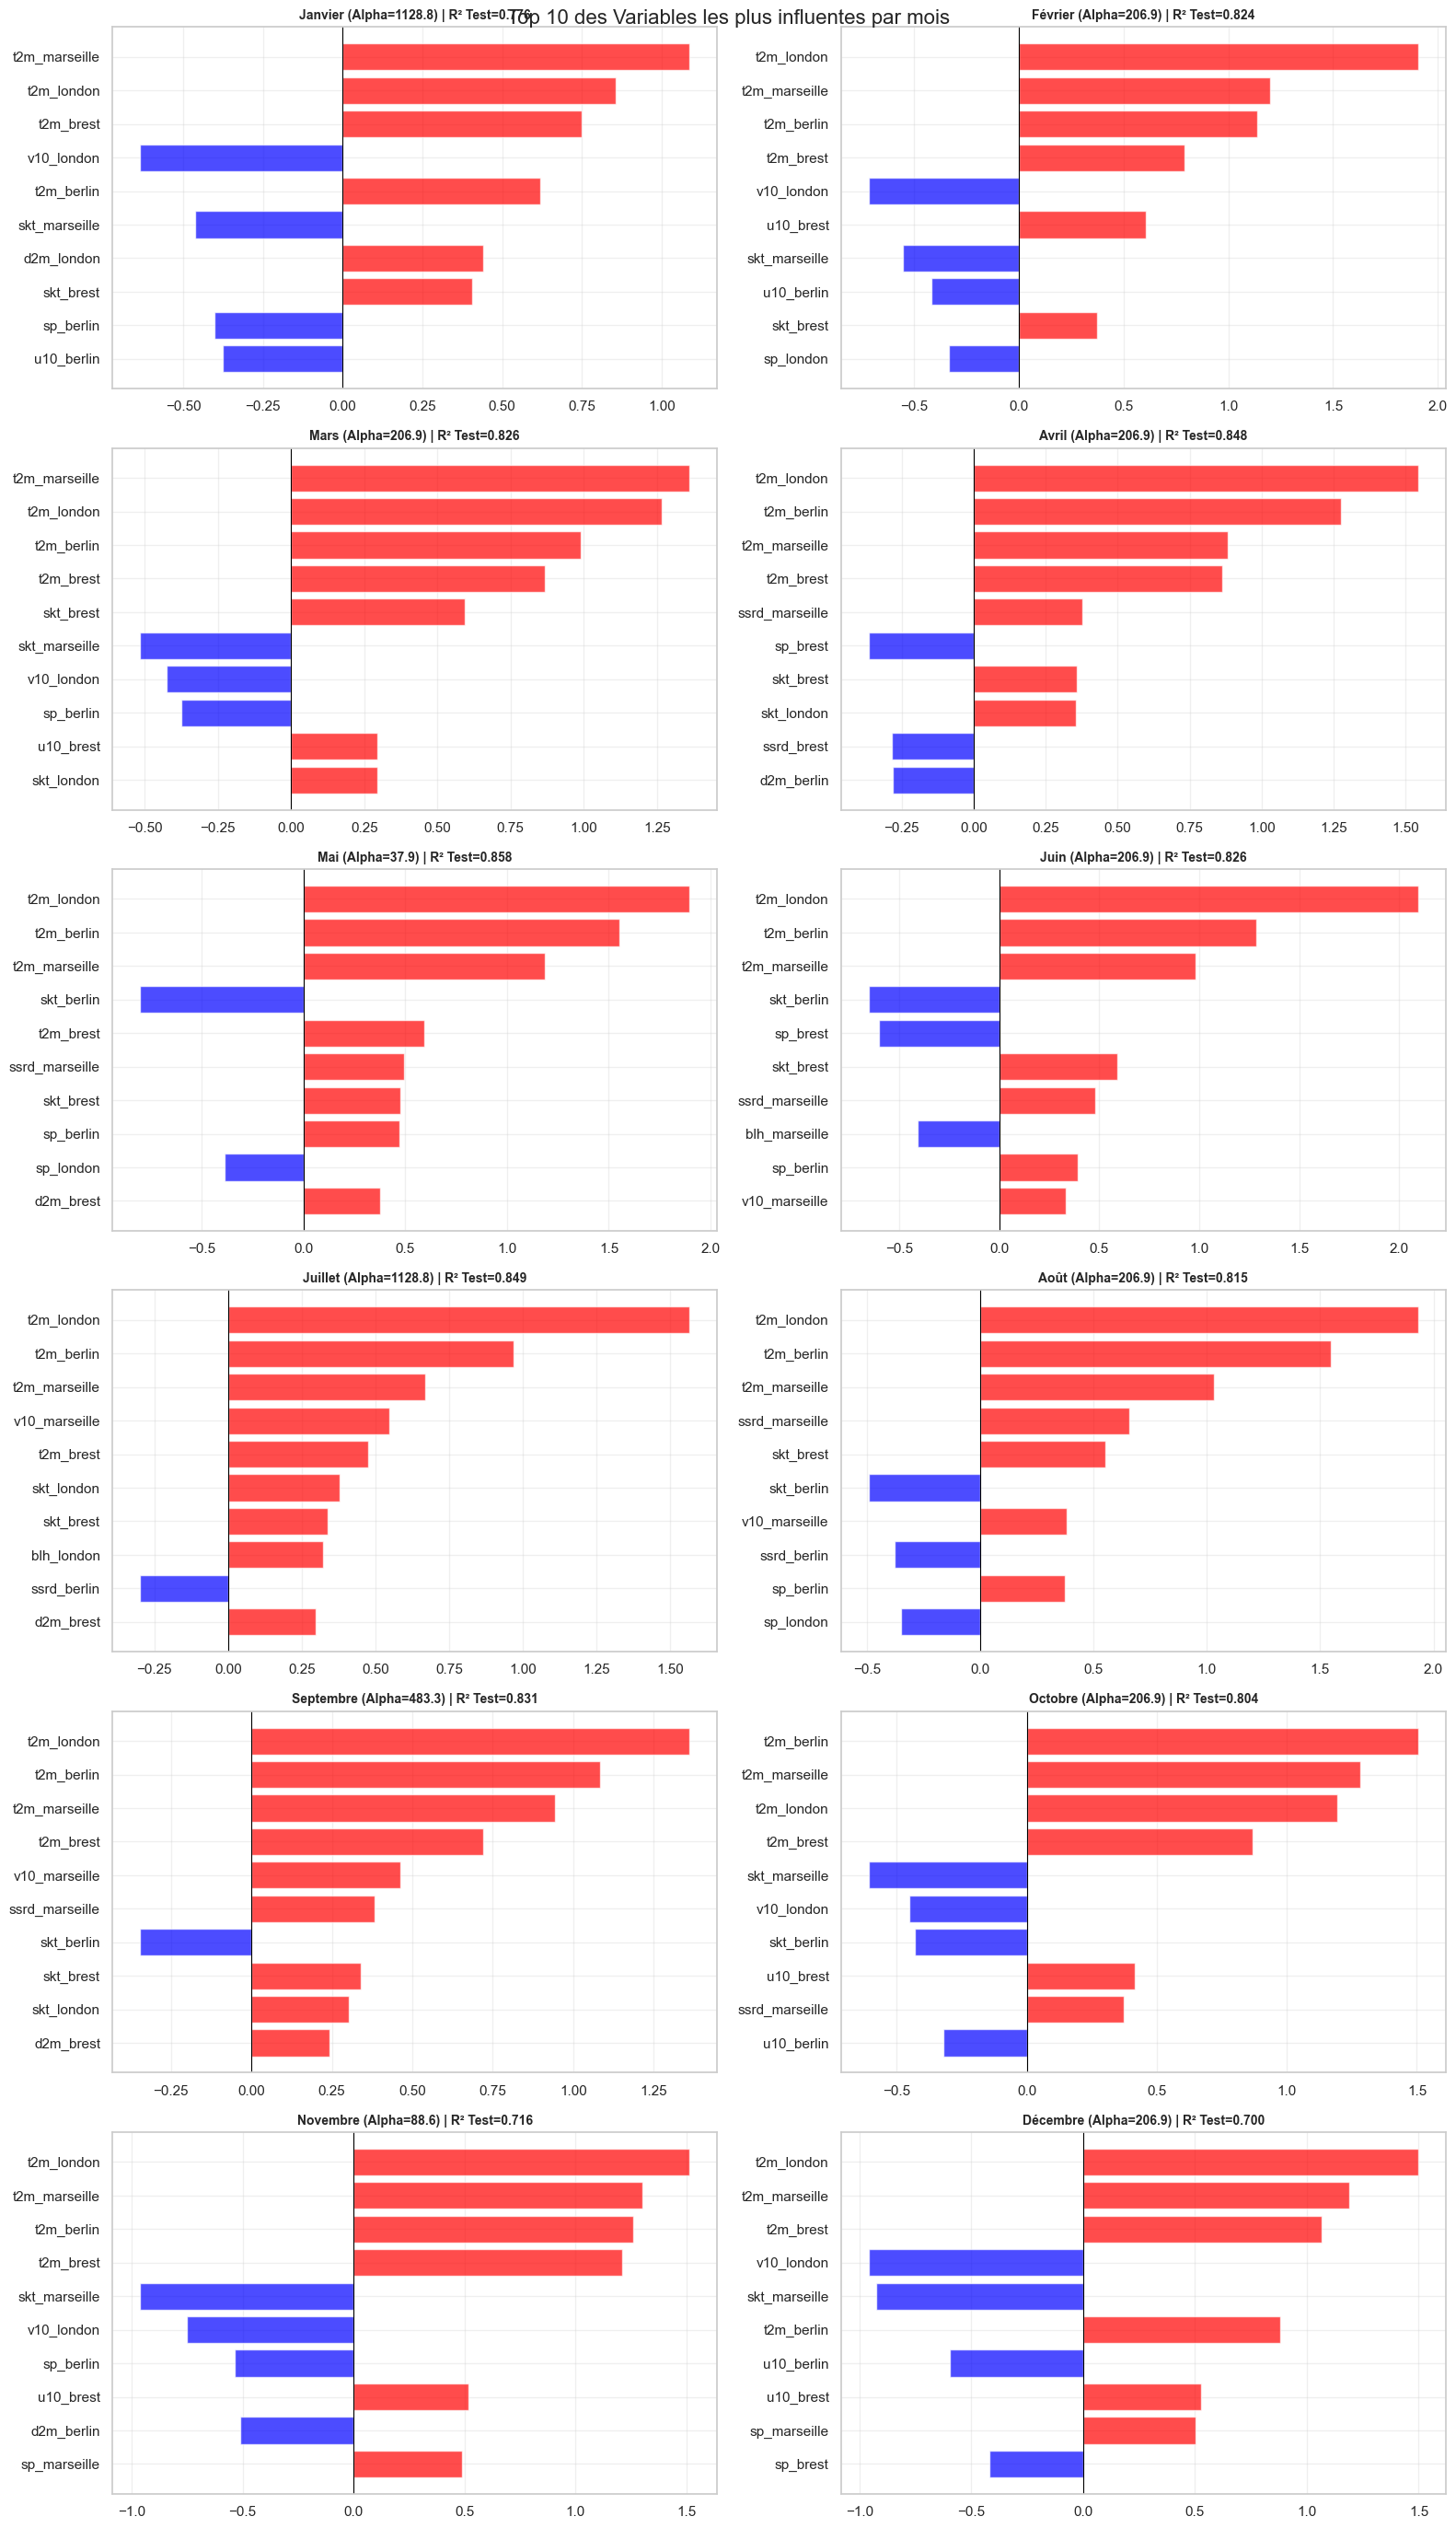

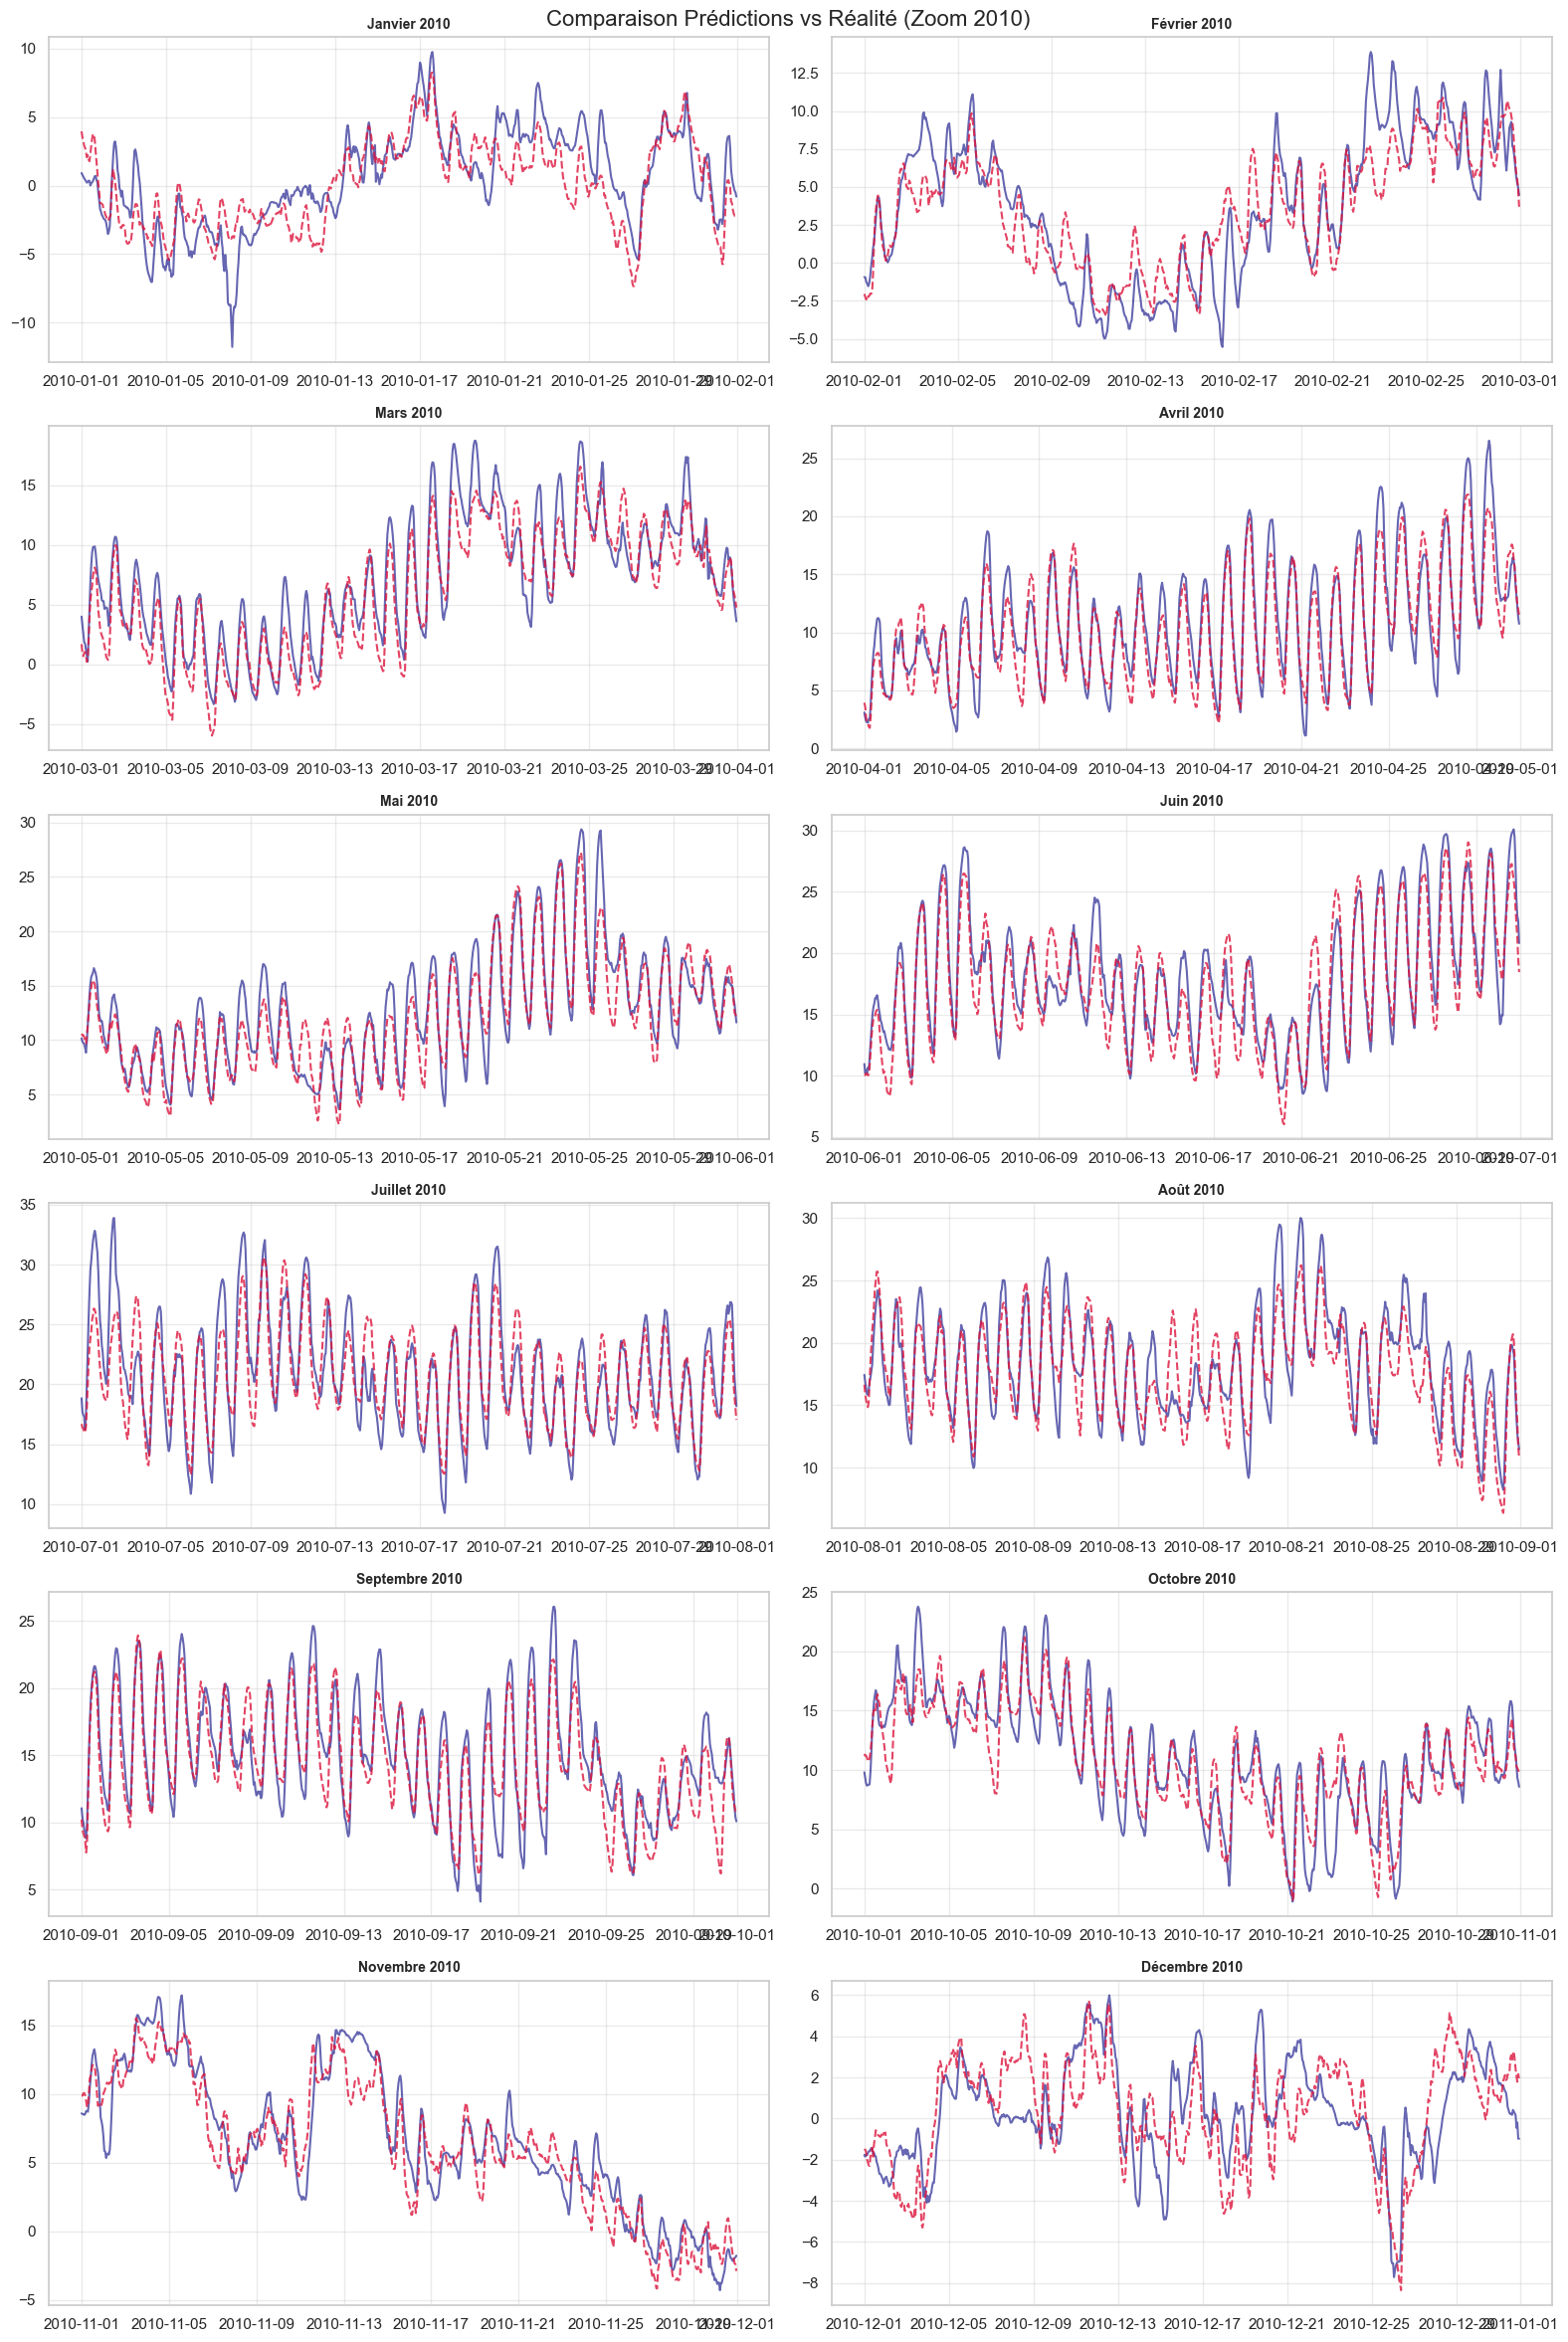

MOIS         | RMSE (Test)     | R² (Test)      
Janvier      | 2.0389 K         | 0.7763
Février      | 1.8997 K         | 0.8241
Mars         | 1.8838 K         | 0.8264
Avril        | 1.9319 K         | 0.8481
Mai          | 1.8303 K         | 0.8580
Juin         | 2.0027 K         | 0.8264
Juillet      | 1.9290 K         | 0.8493
Août         | 2.0848 K         | 0.8151
Septembre    | 1.8710 K         | 0.8309
Octobre      | 1.9206 K         | 0.8036
Novembre     | 2.1193 K         | 0.7157
Décembre     | 2.3147 K         | 0.6999
MOYENNE      | 1.9856 K | 0.8061


In [97]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]
split_date = "2010-01-01"
mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
             'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

# Espace de recherche pour alpha
complexity_rng = np.logspace(-1, 6, 20)

fig_coef, ax_coef = plt.subplots(6, 2, figsize=(16, 28)) 
ax_coef = ax_coef.flatten()

fig_pred, ax_pred = plt.subplots(6, 2, figsize=(16, 24)) 
ax_pred = ax_pred.flatten()

# Listes pour stocker les performances
results_rmse = []
results_r2 = []


for month in range(1, 13):
    # 1. Isolation des données du mois courant
    df_month = df_all[df_all.index.month == month]
    X = df_month[feature_cols]
    y = df_month[target_col]
    
    # 2. Séparation Temporelle
    X_train = X.loc[X.index < split_date]
    y_train = y.loc[y.index < split_date]
    X_test = X.loc[X.index >= split_date]
    y_test = y.loc[y.index >= split_date]
    
    # 3. Normalisation 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. Optimisation de alpha 
    cv_split = TimeSeriesSplit(n_splits=3)
    best_score = -np.inf
    best_alpha = complexity_rng[0]
    
   
    for alpha in complexity_rng:
        reg = Ridge(alpha=alpha)
        scores = cross_val_score(reg, X_train_scaled, y_train, cv=cv_split, scoring='r2')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_alpha = alpha
            
    # 5. Entraînement Final et Prédiction
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_train_scaled, y_train)
    y_pred = final_model.predict(X_test_scaled)
    
    # 6. Évaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results_rmse.append(rmse)
    results_r2.append(r2)

    df_c = pd.DataFrame({'Var': feature_cols, 'Coeff': final_model.coef_})
    df_c['Abs'] = df_c['Coeff'].abs()
    df_top = df_c.sort_values('Abs', ascending=True).tail(10)
    
    colors = ['red' if c > 0 else 'blue' for c in df_top['Coeff']]
    
    ax_c = ax_coef[month-1]
    ax_c.barh(df_top['Var'], df_top['Coeff'], color=colors, alpha=0.7)
    ax_c.set_title(f"{mois_noms[month-1]} (Alpha={best_alpha:.1f}) | R² Test={r2:.3f}", 
                   fontsize=10, fontweight='bold')
    ax_c.axvline(0, color='black', linewidth=0.8)
    ax_c.grid(True, alpha=0.3)

    y_test_2010 = y_test.loc['2010'] - 273.15  
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    y_pred_2010 = y_pred_series.loc['2010'] - 273.15
    
    ax_p = ax_pred[month-1]
    ax_p.plot(y_test_2010.index, y_test_2010, label='Réel', color='navy', alpha=0.6)
    ax_p.plot(y_pred_2010.index, y_pred_2010, label='Prédit', color='crimson', linestyle='--', alpha=0.8)
    ax_p.set_title(f"{mois_noms[month-1]} 2010", fontsize=10, fontweight='bold')
    ax_p.grid(True, alpha=0.4)

fig_coef.suptitle("Top 10 des Variables les plus influentes par mois", fontsize=16)
fig_coef.tight_layout()

fig_pred.suptitle("Comparaison Prédictions vs Réalité (Zoom 2010)", fontsize=16)
fig_pred.tight_layout()

plt.show()

print(f"{'MOIS':<12} | {'RMSE (Test)':<15} | {'R² (Test)':<15}")

for m, rmse, r2 in zip(mois_noms, results_rmse, results_r2):
    print(f"{m:<12} | {rmse:.4f} K         | {r2:.4f}")

print(f"{'MOYENNE':<12} | {np.mean(results_rmse):.4f} K | {np.mean(results_r2):.4f}")

En observant l'évolution des scores R² sur l'année, nous voyons qu'il existe plusieurs tendances :
- Le modèle est très bon sur le printemps (avril - mai - juin). En mai, le modèle atteint son pic de performance avec $R^2_{test}=0.858$. La météo de mi-saison semble suivre des régimes plus prévisibles nécessitant peu de régularisation, $\alpha$ est très bas en mai.
- En hiver (novembre-décembre), il est plus compliqué de prédire la température. Le score de test tombe à $0.716$ en novembre et $0.700$ en décembre.Le modèle capture moins bien les phénomènes hivernaux.

L'examen des 10 coefficients les plus influents révèle ce que le modèle de Ridge a appris :
-  $\texttt{t2m\_londres}$  : C'est presque toujours le prédicteur n°1 (ex: Février, Avril, Juin, Août). Quand il fait chaud à Londres, il fait chaud à Paris.
- $\texttt{t2m\_berlin}$ : Très forte en été et au printemps. Elle capture probablement les vagues de chaleur ou de froid venant de l'Est.
- $\texttt{t2m\_marseille}$ :  Marseille devient un prédicteur crucial en hiver (Janvier, Décembre) et en automne (Octobre, Novembre).

Le modèle utilise des coefficients négatifs pour affiner. 

- Le Vent du Nord ($\texttt{v10\_london}$) : En Janvier et Février, la variable a un coefficient fortement négatif. $\texttt{v10}$ est la composante Nord-Sud du vent. Une valeur positive indique un vent du Sud, une valeur négative un vent du Nord. Ici, le modèle a appris que le vent venant de la zone UK/Mer du Nord est synonyme de refroidissement pour Paris en hiver.

- Les corrections de surface ($\texttt{skt}$ vs $\texttt{t2m}$) : Nous voyons souvent apparaître la température de surface ($\texttt{skt\_berlin}$, $\texttt{skt\_marseille}$) en négatif alors que la température de l'air ($\texttt{t2m}$) de la même ville est positive. Le modèle utilise la différence entre la température de l'air et celle du sol pour capter des informations sur la stabilité de l'atmosphère.

Jusqu'à présent, notre modèle était purement spatial : il tentait de prédire la météo à Paris à l'heure $H$ en utilisant uniquement les données des voisins à l'heure $H$.

Cependant, la météorologie est un système dynamique régi par l'inertie et le déplacement des masses d'air. Par exemple, une perturbation venteuse observée à Londres ou Brest peut mettre plusieurs heures avant d'impacter Paris. Pour capturer cette causalité temporelle, nous allons enrichir notre jeu de données avec des variables retardées (Lags) : $H-1, H-3, H-6, H-9$.

Dimension du nouveau jeu de données:(350624, 98)
Nombre de variables explicatives :88


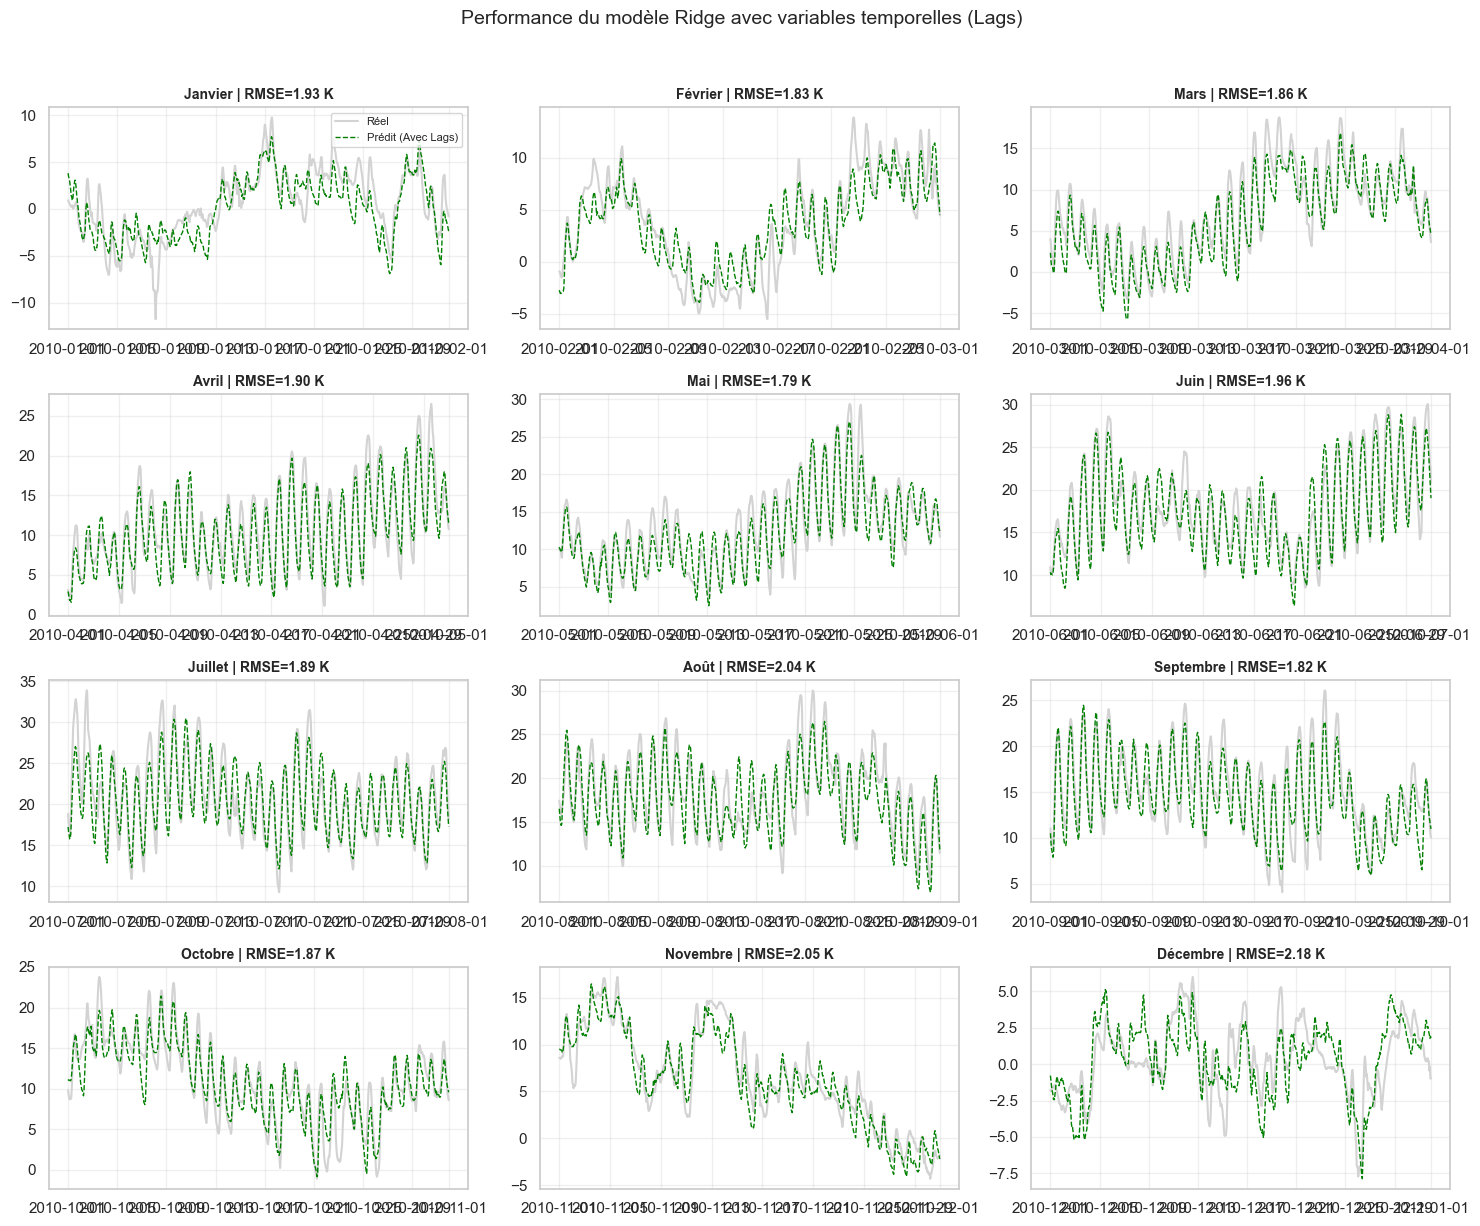

Moyenne RMSE Globale (Avec Lags) : 1.9269 K


In [98]:
# Paramètres des décalages temporels
lags_hours = [1, 3, 6, 9]
neighbor_cities = ['brest', 'london', 'marseille', 'berlin']
vars_to_lag = ['t2m', 'u10', 'v10']  # On cible la température et le vent (vecteurs de déplacement)


# Création des colonnes retardées
for city in neighbor_cities:
    for var in vars_to_lag:
        col_origin = f"{var}_{city}"
        if col_origin in df_all.columns:
            for lag in lags_hours:
                col_lag = f"{col_origin}_lag{lag}"
                df_all[col_lag] = df_all[col_origin].shift(lag)


df_all.dropna(inplace=True)


# On exclut Paris et on garde tout le reste
target_col = "t2m_paris"
feature_cols_v2 = [c for c in df_all.columns if c != target_col and 'paris' not in c]

print(f"Dimension du nouveau jeu de données:{df_all.shape}")
print(f"Nombre de variables explicatives :{len(feature_cols_v2)}")

split_date = "2010-01-01"
complexity_rng = np.logspace(-1, 6, 20)
list_rmse_scores_v2 = []

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for month in range(1, 13):
    
    
    df_month = df_all[df_all.index.month == month]
    X = df_month[feature_cols_v2]
    y = df_month[target_col]
    
    # Split Train/Test
    X_train = X.loc[X.index < split_date]
    y_train = y.loc[y.index < split_date]
    X_test = X.loc[X.index >= split_date]
    y_test = y.loc[y.index >= split_date]
 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    cv_split = TimeSeriesSplit(n_splits=3)
    best_score = -np.inf
    best_alpha = complexity_rng[0]
    
    for alpha in complexity_rng:
        reg = Ridge(alpha=alpha)
        scores = cross_val_score(reg, X_train_scaled, y_train, cv=cv_split, scoring='r2')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_alpha = alpha
            
    # Entraînement Final
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_train_scaled, y_train)
    y_pred = final_model.predict(X_test_scaled)
    
    #  Évaluation 
    rmse_month = np.sqrt(mean_squared_error(y_test, y_pred))
    list_rmse_scores_v2.append(rmse_month)
    
    #  Visualisation 
    y_real_2010 = y_test.loc['2010'] - 273.15 
    y_pred_2010 = pd.Series(y_pred, index=y_test.index).loc['2010'] - 273.15
    
    ax = axes[month-1]
    ax.plot(y_real_2010.index, y_real_2010, label='Réel', color='lightgray', linewidth=1.5)
    ax.plot(y_pred_2010.index, y_pred_2010, label='Prédit (Avec Lags)', color='green', linestyle='--', linewidth=1)
    
    ax.set_title(f"{mois_noms[month-1]} | RMSE={rmse_month:.2f} K", fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
   
    if month == 1:
        ax.legend(loc='upper right', fontsize=8)

plt.suptitle("Performance du modèle Ridge avec variables temporelles (Lags)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

mean_rmse_v2 = np.mean(list_rmse_scores_v2)
print(f"Moyenne RMSE Globale (Avec Lags) : {mean_rmse_v2:.4f} K")

Features sélectionnées : 117
RMSE Global : 1.9216 K
R² Global   : 0.9288
Moyenne RMSE mensuelle : 1.9011 K


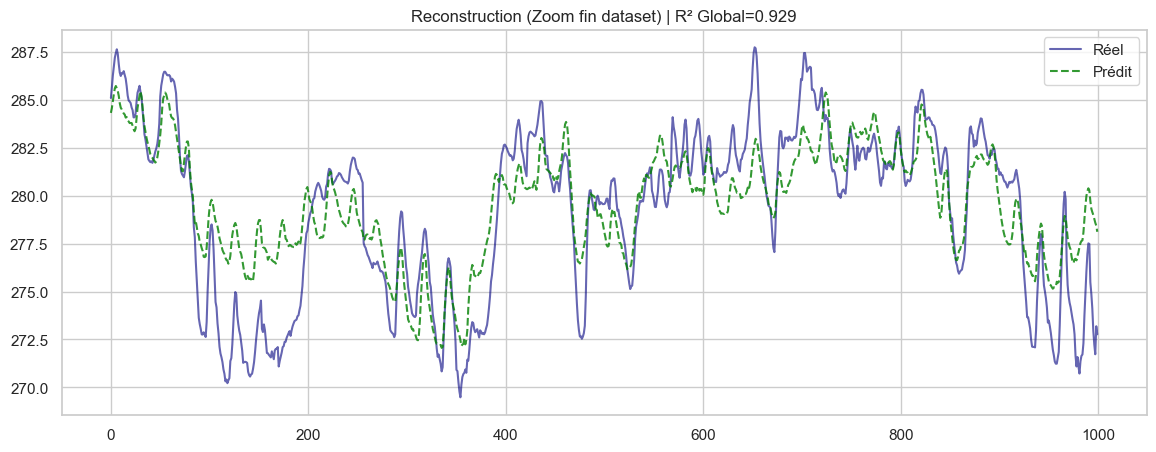

In [99]:
lags = [1, 3, 6, 12, 24]
neighbor_cities = ['brest', 'london', 'marseille', 'berlin']
vars_neighbors = ['t2m', 'u10', 'v10']

for city in neighbor_cities:
    for var in vars_neighbors:
        col = f"{var}_{city}"
        if col in df_all.columns:
            for lag in lags:
                df_all[f'{col}_lag{lag}'] = df_all[col].shift(lag)


for lag in lags:
    df_all[f't2m_paris_lag{lag}'] = df_all['t2m_paris'].shift(lag)

df_all.dropna(inplace=True)


feature_cols = [c for c in df_all.columns if ('paris' not in c) or ('paris' in c and 'lag' in c)]
target_col = "t2m_paris"

col_indices = {name: i for i, name in enumerate(feature_cols)}
paris_lag_indices = {lag: col_indices[f't2m_paris_lag{lag}'] for lag in lags}

print(f"Features sélectionnées : {len(feature_cols)}")

scores_rmse, scores_r2 = [], []
all_y_true, all_y_pred = [], []

split_date = "2010-01-01"
scaler = StandardScaler()

for month in range(1, 13):
    # Train (avant 2010)
    df_train = df_all[(df_all.index.month == month) & (df_all.index < split_date)]
    X_train = df_train[feature_cols].values
    y_train = df_train[target_col].values
    
    scaler.fit(X_train)
    model = Ridge(alpha=10.0)
    model.fit(scaler.transform(X_train), y_train)
    
    # Test (après 2010) 
    df_test_global = df_all[(df_all.index.month == month) & (df_all.index >= split_date)]
    
    for year in df_test_global.index.year.unique():
        df_test_curr = df_test_global[df_test_global.index.year == year]
        if df_test_curr.empty: continue
            
        X_test = df_test_curr[feature_cols].values
        y_test = df_test_curr[target_col].values
        y_pred_chunk = []
        
        for i in range(len(X_test)):
            row = X_test[i].copy()
            
            # Mise à jour des lags avec les prédictions précédentes
            for lag, col_idx in paris_lag_indices.items():
                if i - lag >= 0:
                    row[col_idx] = y_pred_chunk[i - lag]
            
            pred = model.predict(scaler.transform(row.reshape(1, -1)))[0]
            y_pred_chunk.append(pred)
        
        # Stockage des résultats
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred_chunk)
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred_chunk)))
        scores_r2.append(r2_score(y_test, y_pred_chunk))

rmse_global = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
r2_global = r2_score(all_y_true, all_y_pred)

print(f"RMSE Global : {rmse_global:.4f} K")
print(f"R² Global   : {r2_global:.4f}")
print(f"Moyenne RMSE mensuelle : {np.mean(scores_rmse):.4f} K")

plt.figure(figsize=(14, 5))
plt.plot(all_y_true[-1000:], label='Réel', color='navy', alpha=0.6)
plt.plot(all_y_pred[-1000:], label='Prédit', color='green', linestyle='--', alpha=0.8)
plt.title(f"Reconstruction (Zoom fin dataset) | R² Global={r2_global:.3f}")
plt.legend()
plt.show()

On observe qu'il n'y a pas d'amélioration significative du RMSE par rapport au modèle précédent. Le gain est très faible. Nous voyons également que ce modèle prend très peu en compte les grandes variations. L'utilisation des valeurs prédites de la température sur une panne d'un mois n'est pas pertinente.

-> Panne 1 jours : RMSE = 1.6129 K      
-> Panne 3 jours : RMSE = 1.8111 K      
-> Panne 7 jours : RMSE = 1.8801 K      
-> Panne 14 jours : RMSE = 1.9047 K      
-> Panne 21 jours : RMSE = 1.9106 K      
-> Panne 30 jours : RMSE = 1.9149 K      


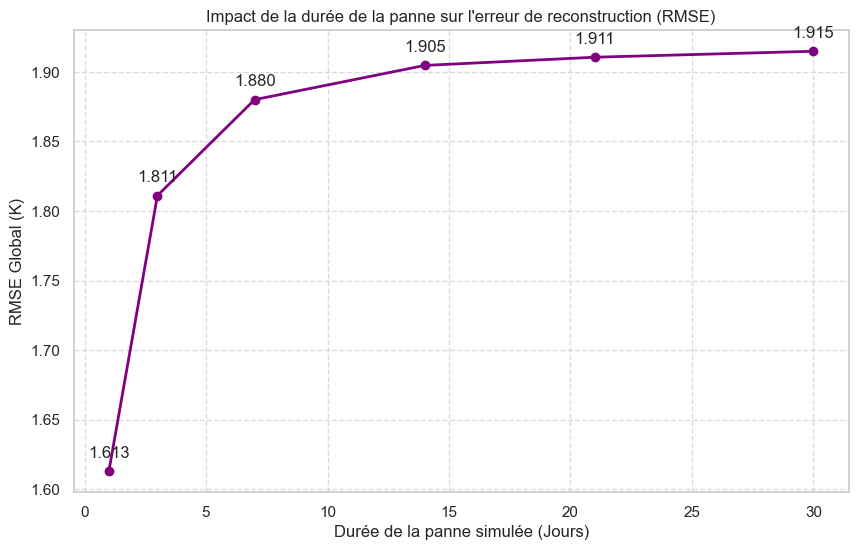

In [100]:
# Durées de panne à tester (en jours)
test_durations_days = [1, 3, 7, 14, 21, 30]

results_sensitivity = []

for duration in test_durations_days:
    
    reset_hours = duration * 24  
    all_y_true_dur = []
    all_y_pred_dur = []
     
    for month in range(1, 13):
        
        # 1. ENTRAINEMENT
        df_train = df_all[(df_all.index.month == month) & (df_all.index < split_date)]
        X_train = df_train[feature_cols].values
        y_train = df_train[target_col].values
        
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        
        model = Ridge(alpha=10.0)
        model.fit(X_train_scaled, y_train)
        
        # 2. TEST 
        df_test_global = df_all[(df_all.index.month == month) & (df_all.index >= split_date)]
        years = df_test_global.index.year.unique()
        
        for year in years:
            df_test_curr = df_test_global[df_test_global.index.year == year]
            if df_test_curr.empty: continue
                
            X_test_vals = df_test_curr[feature_cols].values
            y_test_vals = df_test_curr[target_col].values
            
            y_pred_chunk = []
            
            
            last_reset_idx = 0 
            
            for i in range(len(X_test_vals)):
                
                
                if (i - last_reset_idx) >= reset_hours:
                    last_reset_idx = i 
                
                
                row = X_test_vals[i].copy()
                
                for lag, col_idx in paris_lag_indices.items():
                    target_idx = i - lag
                    
                    
                    if target_idx >= last_reset_idx:
                        
                        pred_val = y_pred_chunk[target_idx]
                        row[col_idx] = pred_val
                    
                    
                
                # Prédiction
                row_scaled = scaler.transform(row.reshape(1, -1))
                pred = model.predict(row_scaled)[0]
                y_pred_chunk.append(pred)
            
            all_y_true_dur.extend(y_test_vals)
            all_y_pred_dur.extend(y_pred_chunk)

    # Calcul du RMSE global pour cette durée
    rmse_dur = np.sqrt(mean_squared_error(all_y_true_dur, all_y_pred_dur))
    results_sensitivity.append(rmse_dur)
    print(f"-> Panne {duration} jours : RMSE = {rmse_dur:.4f} K      ")



plt.figure(figsize=(10, 6))
plt.plot(test_durations_days, results_sensitivity, marker='o', linestyle='-', color='purple', linewidth=2)

plt.title("Impact de la durée de la panne sur l'erreur de reconstruction (RMSE)")
plt.xlabel("Durée de la panne simulée (Jours)")
plt.ylabel("RMSE Global (K)")
plt.grid(True, linestyle='--', alpha=0.7)


for x, y in zip(test_durations_days, results_sensitivity):
    plt.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

On observe que l'utilisation des données prédites peut être pertinente pour des pannes courtes (quelques heures). Cependant, pour des pannes longues (plusieurs jours ou semaines), l'erreur s'accumule rapidement, rendant les prédictions peu fiables.

## Simulation des autres variables

Jusqu'à présent, nous nous sommes concentrés sur la température (`t2m`). Cependant, une panne de station affecte l'ensemble des capteurs. Nous allons maintenant appliquer notre méthodologie (modèle Ridge mensuel) à **toutes les variables disponibles** (pression, vent, humidité, etc.) pour évaluer la difficulté de reconstruction de chacune.

Pour comparer des grandeurs physiques très différentes (ex: Pression en $10^5$ Pa vs Couverture nuageuse entre 0 et 1), nous utiliserons, en plus du RMSE et du $R^2$, le **NRMSE (Normalized RMSE)** :
$$NRMSE = \frac{RMSE}{\sigma_{réelle}}$$
Cet indicateur mesure l'erreur relative par rapport à la variabilité naturelle de la grandeur. Un NRMSE faible (< 0.5) indique une excellente reconstruction.

In [101]:
# Liste des variables cibles à Paris
targets_vars = ['t2m', 'skt', 'd2m', 'u10', 'v10', 'tcc', 'sp', 'ssrd', 'blh']
targets_vars = [v for v in targets_vars if f"{v}_paris" in df_all.columns]

results_data = []
split_date = "2010-01-01"
complexity_rng = np.logspace(-1, 6, 10)

print(f"{'Variable':<10} | {'RMSE':<12} | {'R² Score':<12} | {'NRMSE':<12}")

for var_name in targets_vars:
    target_col = f"{var_name}_paris"
    
    
    feature_cols = [c for c in df_all.columns if 'paris' not in c]
    
    all_y_true = []
    all_y_pred = []
    
    
    for month in range(1, 13):
        
        # 1. Préparation des données du mois
        df_month = df_all[df_all.index.month == month]
        X = df_month[feature_cols]
        y = df_month[target_col]
        
        # 2. Split Temporel
        X_train = X.loc[X.index < split_date]
        y_train = y.loc[y.index < split_date]
        X_test = X.loc[X.index >= split_date]
        y_test = y.loc[y.index >= split_date]
        
        # 3. Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 4. Optimisation Hyperparamètre 
        best_score = -np.inf
        best_alpha = 1.0
        
        # Recherche simple du meilleur alpha
        for alpha in complexity_rng:
            reg = Ridge(alpha=alpha)
            # Validation croisée rapide 
            scores = cross_val_score(reg, X_train_scaled, y_train, cv=TimeSeriesSplit(n_splits=3), scoring='r2')
            if scores.mean() > best_score:
                best_score = scores.mean()
                best_alpha = alpha
        
        # 5. Entraînement Final & Prédiction
        model = Ridge(alpha=best_alpha)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
    rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
    r2 = r2_score(all_y_true, all_y_pred)
    std_dev = np.std(all_y_true)
    nrmse = rmse / std_dev if std_dev != 0 else np.inf
    
    print(f"{var_name:<10} | {rmse:<12.4f} | {r2:<12.4f} | {nrmse:<12.4f}")
    
    results_data.append({
        'Variable': var_name,
        'RMSE': rmse,
        'R2': r2,
        'NRMSE': nrmse
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values(by='NRMSE', ascending=True).reset_index(drop=True)

print("CLASSEMENT FINAL (Critère :NRMSE croissant)")
print(df_results[['Variable', 'NRMSE', 'R2', 'RMSE']])

Variable   | RMSE         | R² Score     | NRMSE       
t2m        | 1.8661       | 0.9329       | 0.2591      
skt        | 2.0490       | 0.9339       | 0.2571      
d2m        | 2.0331       | 0.8638       | 0.3691      
u10        | 1.0282       | 0.8318       | 0.4101      
v10        | 1.2479       | 0.8064       | 0.4401      
tcc        | 0.3192       | 0.2700       | 0.8544      


KeyboardInterrupt: 

Le classement des performances révèle une distinction nette entre quatre catégories de variables météorologiques, directement liée à leur échelle spatiale :

1. Les variables à grande échelle sur lesquelle la performance est très bonne
* Pression de surface (`sp`): C'est la variable la mieux reconstruite ($R^2 \approx 0.99$, $NRMSE \approx 0.11$).
* La pression atmosphérique est un phénomène qui varie sur des grandes distances. La dépression présente à Londres ou Brest s'étend presque systématiquement jusqu'à Paris. 

2. Les variables thermodynamiques avec une bonne performance
* Températures (`t2m`, `skt`) : Avec un $R^2 > 0.93$, la reconstruction est très fiable (erreur moyenne $< 2°C$).
*  La température de la masse d'air est spatialement cohérente. 

3. Les variables dynamiques et radiatives qui ont une performance correcte
* Vent (`u10`, `v10`) et Radiation (`ssrd`, `d2m`) : Les scores restent corrects ($R^2$ entre 0.80 et 0.87).
*  Ces variables sont plus sensibles aux effets locaux. Les voisins donnent la tendance générale

# Prédiction de la pression à Paris

Nous allons faire un focus sur la pression à Paris, qui est la variable la plus facile à reconstruire. 

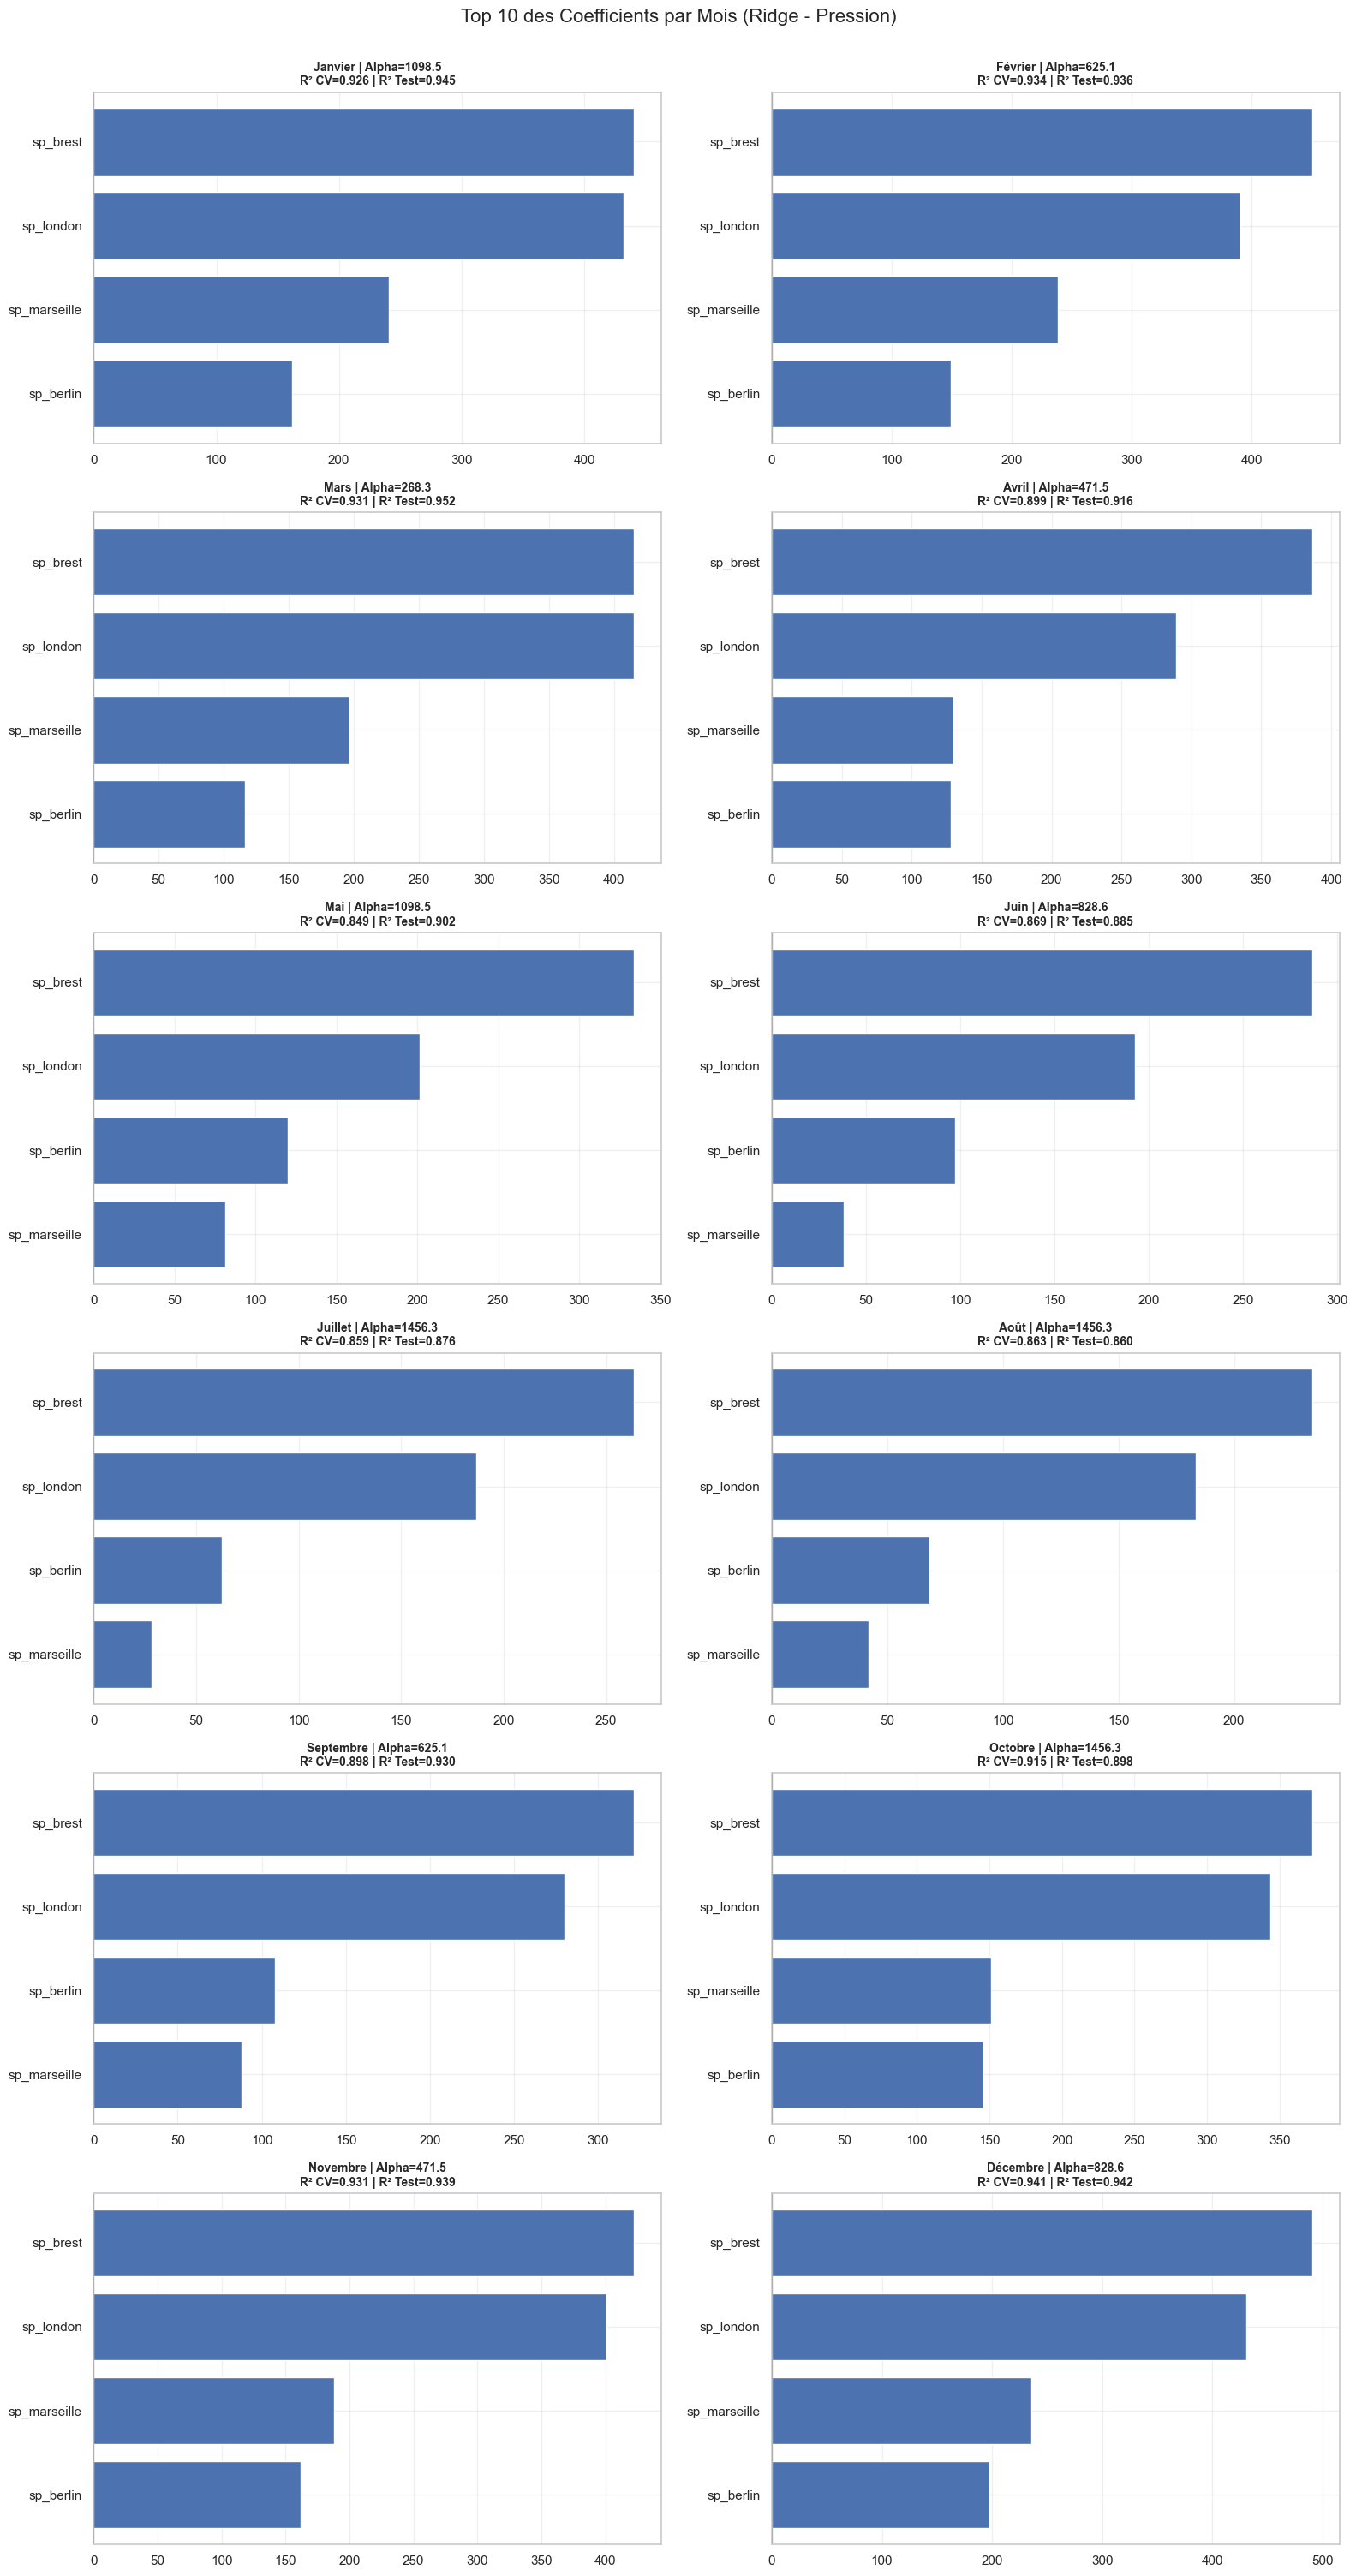

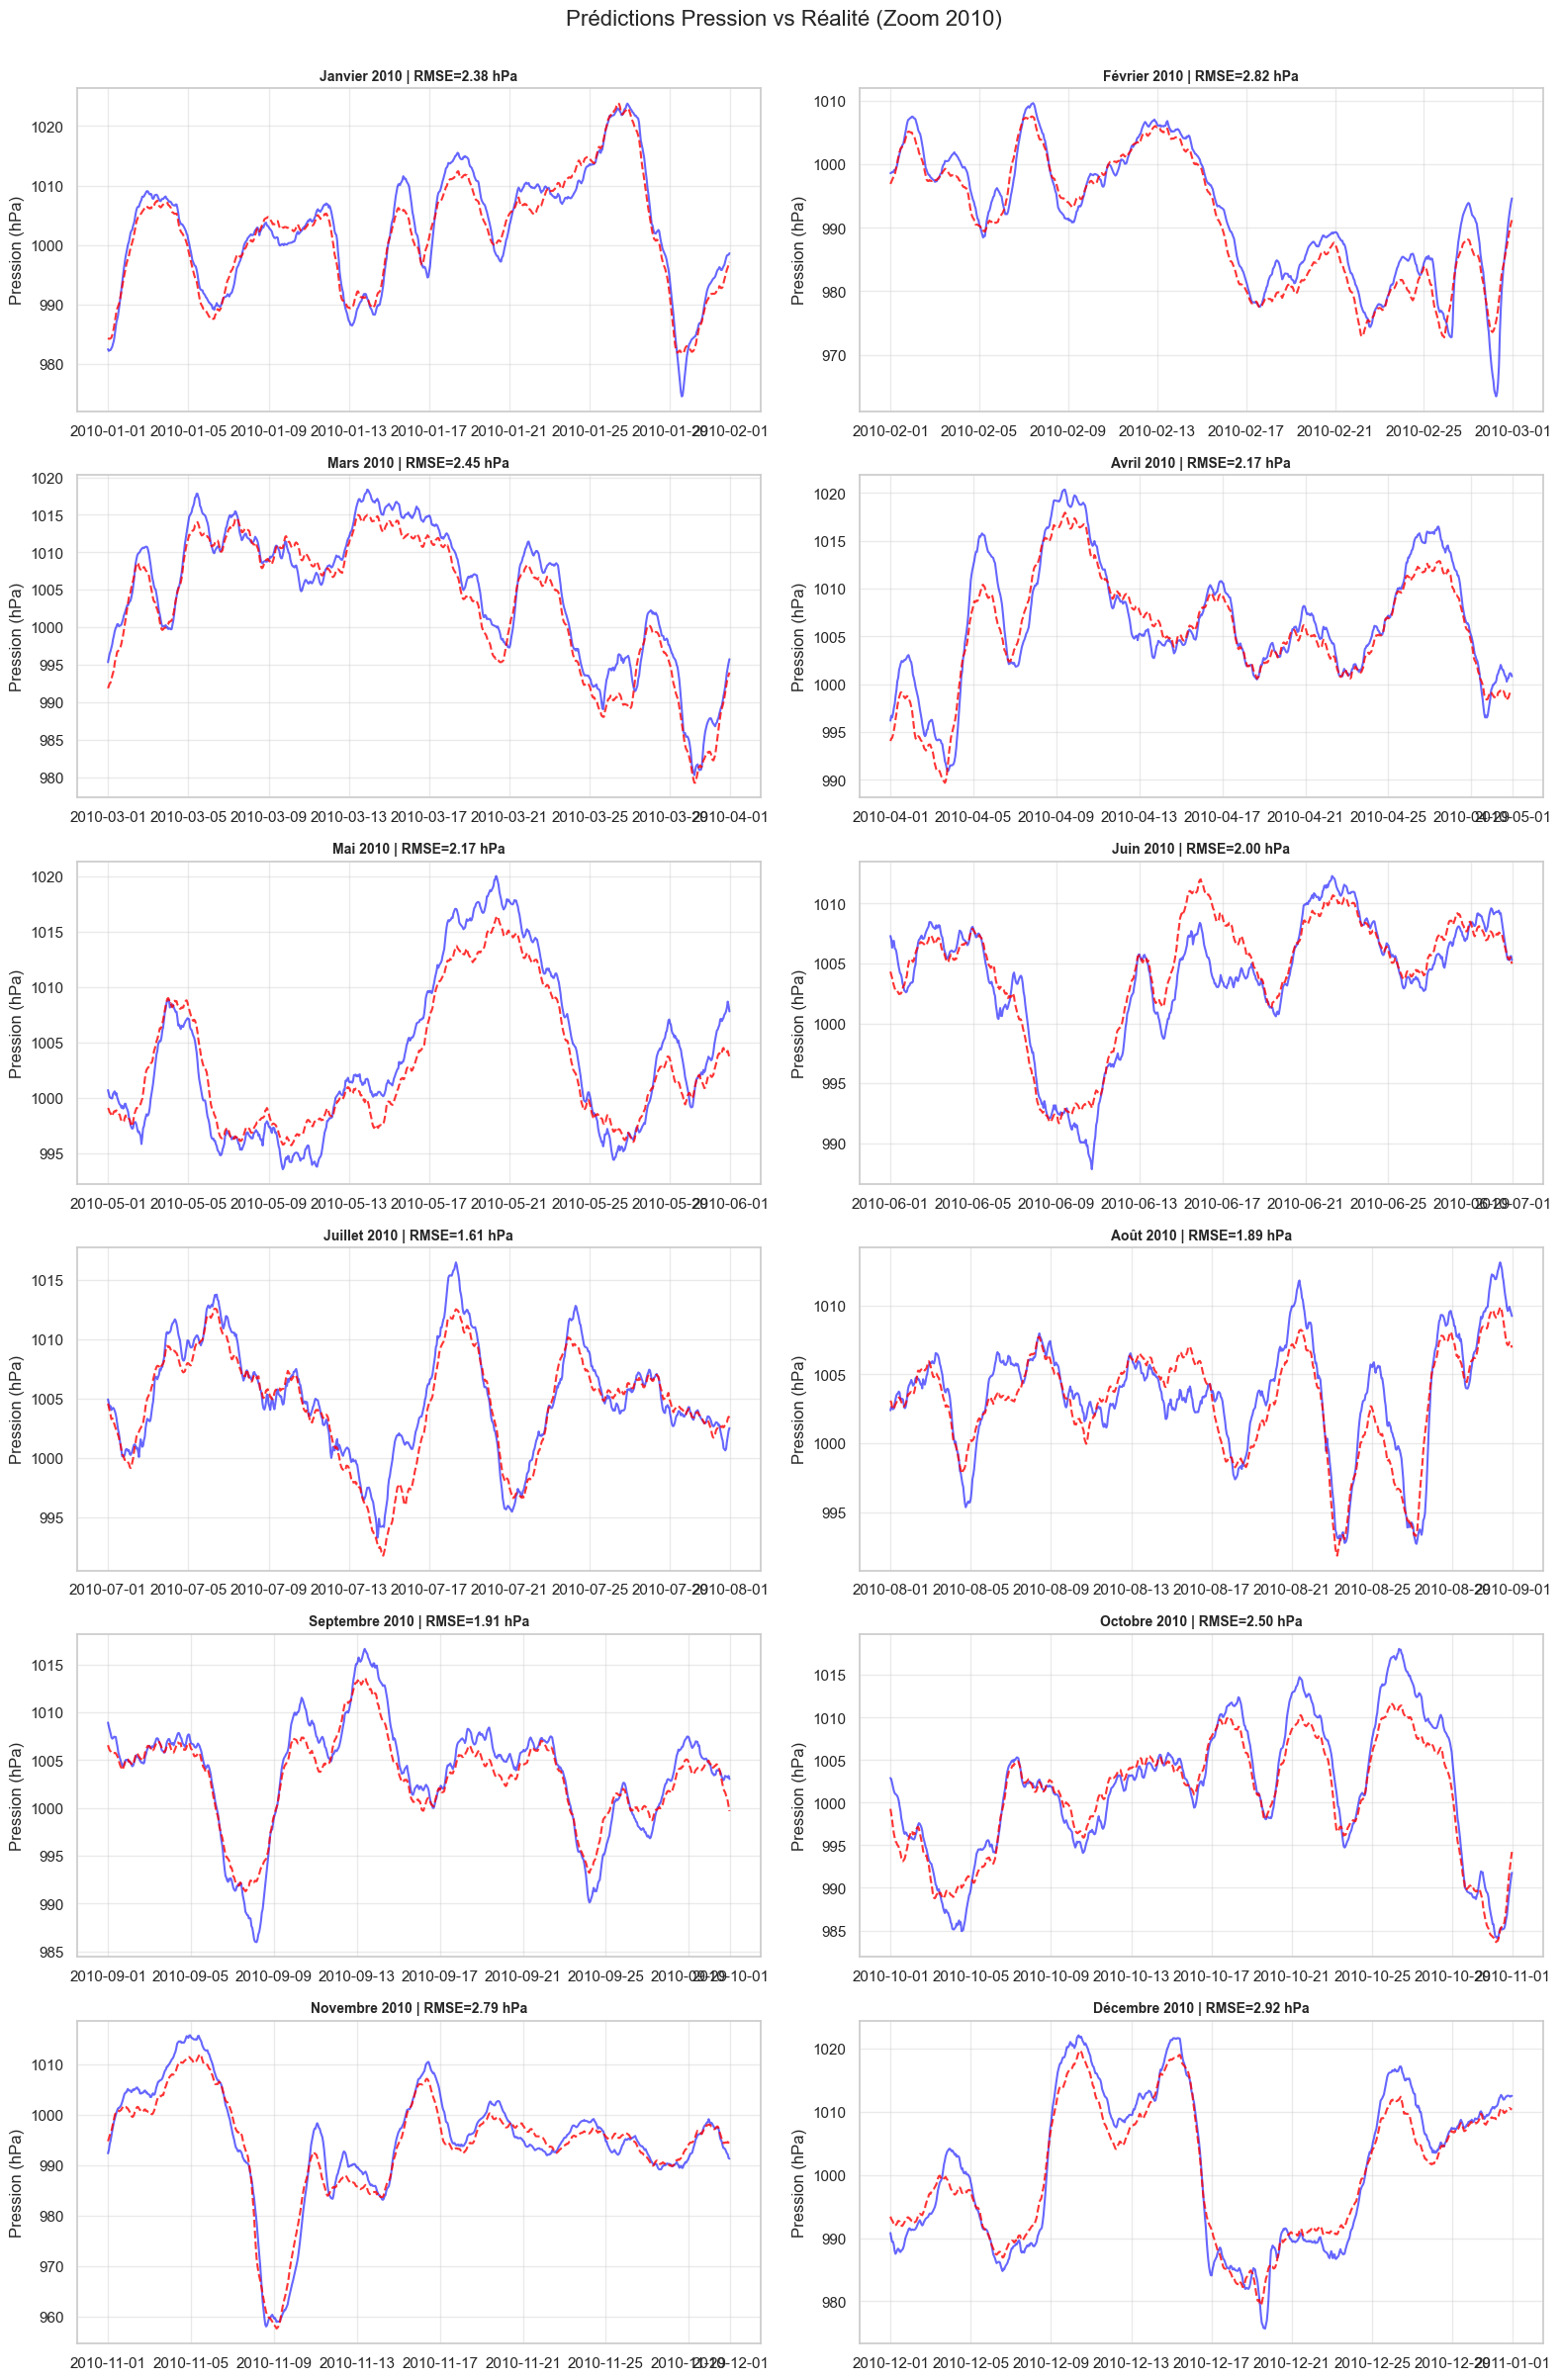

In [102]:


target_col = "sp_paris"
# On sélectionne uniquement les colonnes de pression des autres villes
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris') and c.startswith('sp')]
split_date = "2010-01-01"

complexity_rng = np.logspace(-1, 5, 50)

mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

fig_coef, ax_coef = plt.subplots(6, 2, figsize=(16, 30))
ax_coef = ax_coef.flatten()

fig_pred, ax_pred = plt.subplots(6, 2, figsize=(16, 24))
ax_pred = ax_pred.flatten()

for month in range(1, 13):
    
    df_month = df_all[df_all.index.month == month]
    
    X = df_month[feature_cols]
    y = df_month[target_col]
    
    # Split
    X_cv = X.loc[X.index < split_date]
    y_cv = y.loc[y.index < split_date]
    X_test = X.loc[X.index >= split_date]
    y_test = y.loc[y.index >= split_date]
    
    # Scaling
    scaler = StandardScaler()
    X_cv_scaled = scaler.fit_transform(X_cv)
    X_test_scaled = scaler.transform(X_test)
    
    # Recherche Alpha
    cv_split = TimeSeriesSplit(n_splits=3)
    r2_validation = []
    
    for alpha in complexity_rng:
        reg = Ridge(alpha=alpha)
        scores = cross_val_score(reg, X_cv_scaled, y_cv, cv=cv_split, scoring='r2')
        r2_validation.append(scores.mean())
        
    best_idx = np.argmax(r2_validation)
    best_alpha = complexity_rng[best_idx]
    best_r2_val = r2_validation[best_idx]
    
    # Entraînement Final
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_cv_scaled, y_cv)
    
    y_pred = final_model.predict(X_test_scaled)
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    
    real_r2_test = r2_score(y_test, y_pred)

    
    df_c = pd.DataFrame({'Var': feature_cols, 'Coeff': final_model.coef_})
    df_c['Abs'] = df_c['Coeff'].abs()
    df_top = df_c.sort_values('Abs', ascending=True).tail(10)
    
    ax_c = ax_coef[month-1]

    ax_c.barh(df_top['Var'], df_top['Coeff']) 
    
    ax_c.set_title(f"{mois_noms[month-1]} | Alpha={best_alpha:.1f}\nR² CV={best_r2_val:.3f} | R² Test={real_r2_test:.3f}", fontsize=10, fontweight='bold')
    ax_c.grid(True, alpha=0.3)
    ax_c.axvline(0, color='black', linewidth=0.8)
    
    
    y_real_2010 = y_test.loc['2010'] / 100.0 
    y_pred_2010 = y_pred_series.loc['2010'] / 100.0
    
    rmse_2010 = np.sqrt(mean_squared_error(y_real_2010, y_pred_2010))
    
    ax_p = ax_pred[month-1]
    ax_p.plot(y_real_2010.index, y_real_2010, label='Réel', color='blue', alpha=0.6)
    ax_p.plot(y_pred_2010.index, y_pred_2010, label='Prédit', color='red', linestyle='--', alpha=0.8)
    
    ax_p.set_title(f"{mois_noms[month-1]} 2010 | RMSE={rmse_2010:.2f} hPa", fontsize=10, fontweight='bold')
    ax_p.set_ylabel("Pression (hPa)")
    ax_p.grid(True, alpha=0.4)

fig_coef.suptitle("Top 10 des Coefficients par Mois (Ridge - Pression)", fontsize=16, y=1.002)
fig_coef.tight_layout()

fig_pred.suptitle("Prédictions Pression vs Réalité (Zoom 2010)", fontsize=16, y=1.002)
fig_pred.tight_layout()

plt.show()

# Prédiction des précipitations à Paris

Nous allons maintenant essayer de prédire les précipitations à Paris, qui est la variable la plus difficile à reconstruire par son caractère local et chaotique.

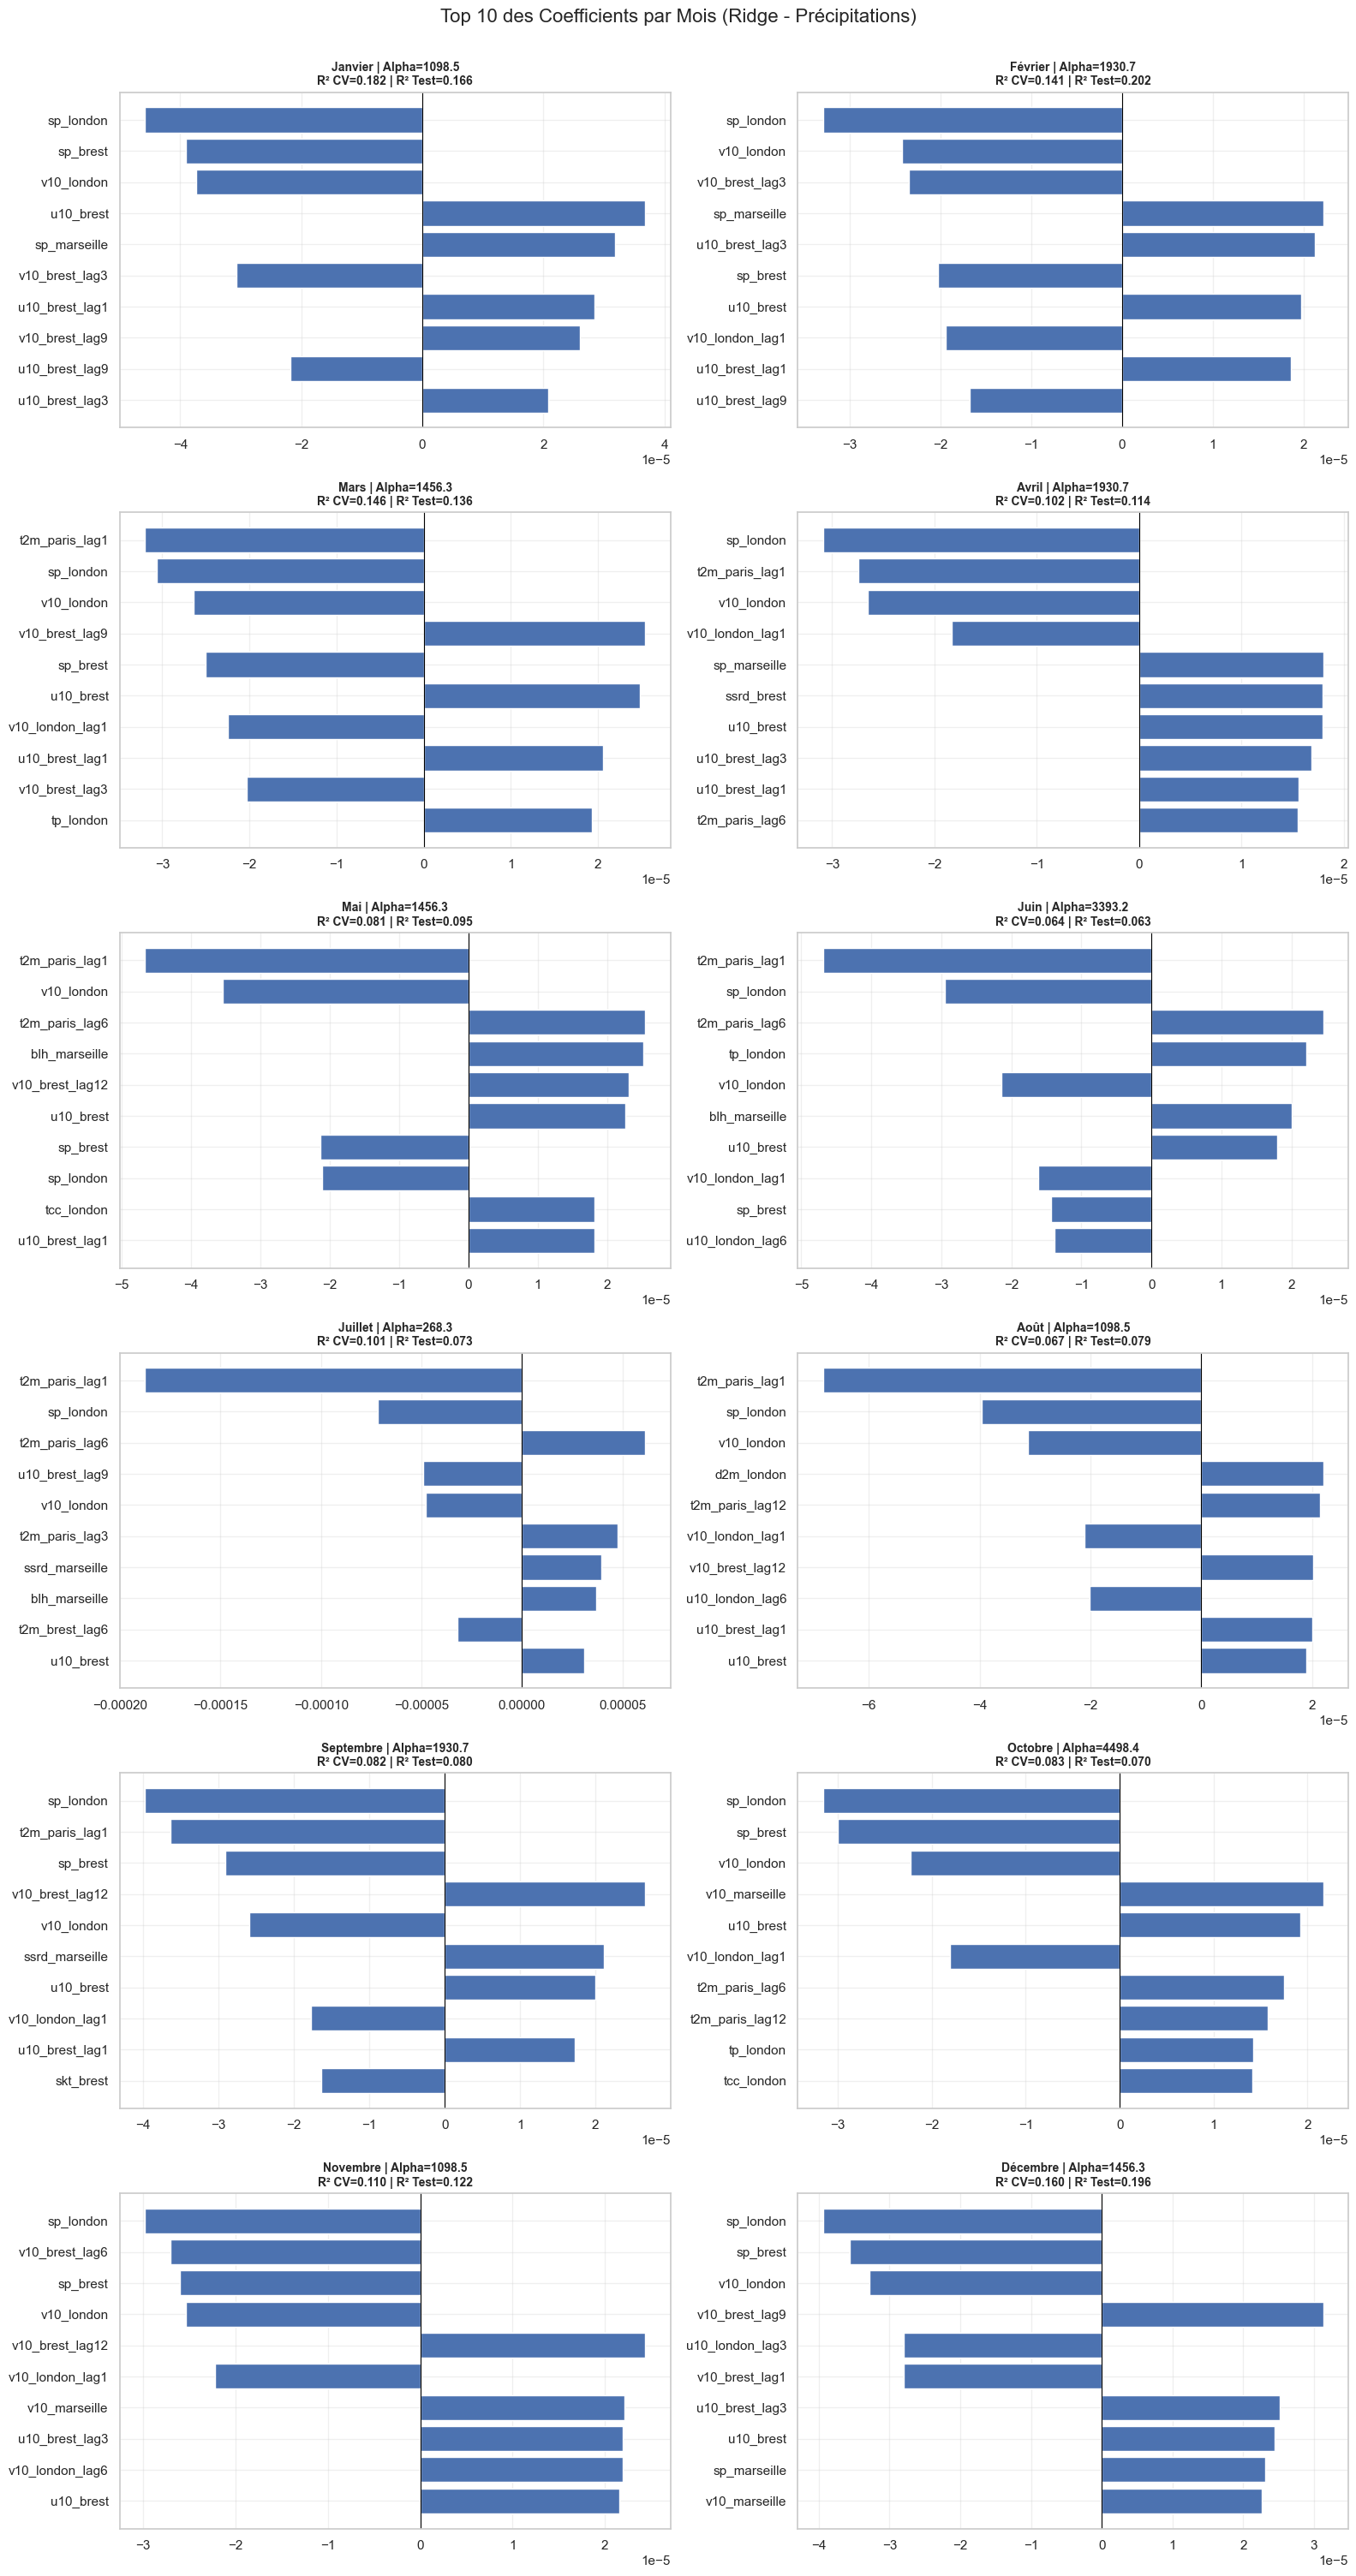

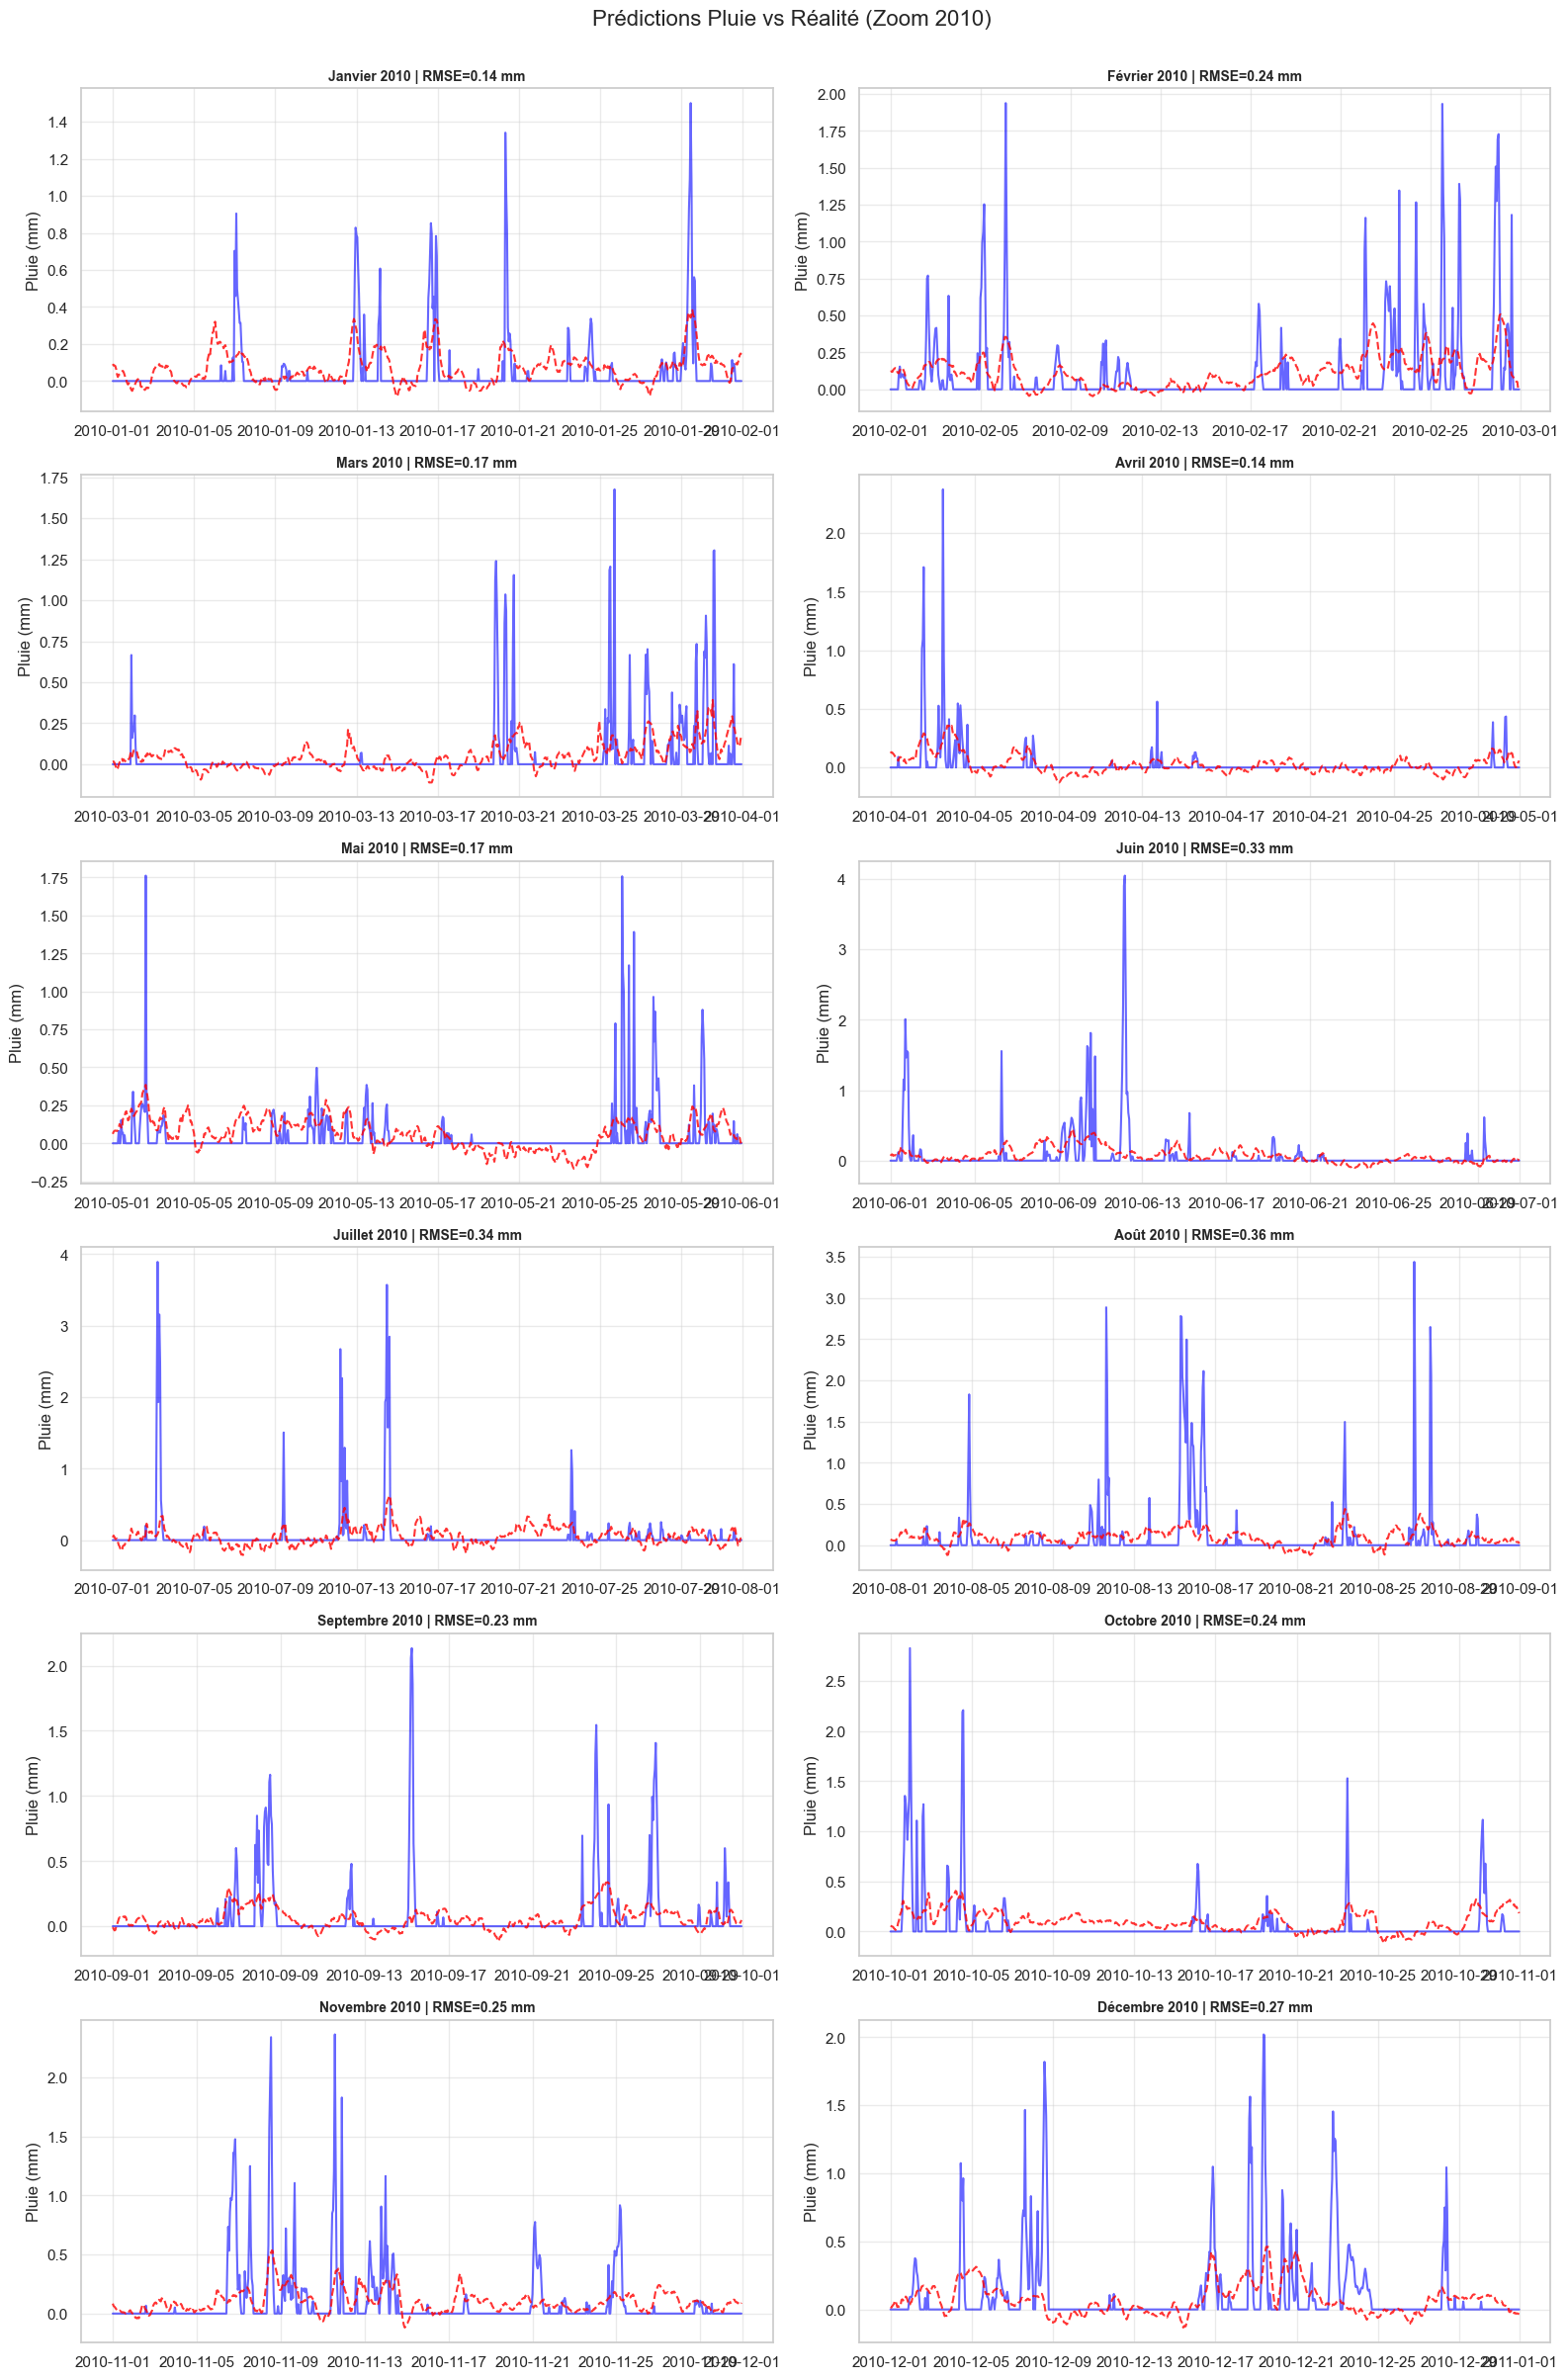

In [103]:
target_col = "tp_paris"
# Toutes les variables sauf celles de Paris
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]
split_date = "2010-01-01"

complexity_rng = np.logspace(-1, 5, 50)

mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

fig_coef, ax_coef = plt.subplots(6, 2, figsize=(16, 30))
ax_coef = ax_coef.flatten()

fig_pred, ax_pred = plt.subplots(6, 2, figsize=(16, 24))
ax_pred = ax_pred.flatten()

for month in range(1, 13):
    
    df_month = df_all[df_all.index.month == month]
    
    X = df_month[feature_cols]
    y = df_month[target_col]
    
    X_cv = X.loc[X.index < split_date]
    y_cv = y.loc[y.index < split_date]
    X_test = X.loc[X.index >= split_date]
    y_test = y.loc[y.index >= split_date]
    
    scaler = StandardScaler()
    X_cv_scaled = scaler.fit_transform(X_cv)
    X_test_scaled = scaler.transform(X_test)
    
    cv_split = TimeSeriesSplit(n_splits=3)
    r2_validation = []
    
    for alpha in complexity_rng:
        reg = Ridge(alpha=alpha)
        scores = cross_val_score(reg, X_cv_scaled, y_cv, cv=cv_split, scoring='r2')
        r2_validation.append(scores.mean())
        
    best_idx = np.argmax(r2_validation)
    best_alpha = complexity_rng[best_idx]
    best_r2_val = r2_validation[best_idx]
    
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_cv_scaled, y_cv)
    
    y_pred = final_model.predict(X_test_scaled)
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    
    real_r2_test = r2_score(y_test, y_pred)

    df_c = pd.DataFrame({'Var': feature_cols, 'Coeff': final_model.coef_})
    df_c['Abs'] = df_c['Coeff'].abs()
    df_top = df_c.sort_values('Abs', ascending=True).tail(10)
    
    ax_c = ax_coef[month-1]
    ax_c.barh(df_top['Var'], df_top['Coeff'])
    
    ax_c.set_title(f"{mois_noms[month-1]} | Alpha={best_alpha:.1f}\nR² CV={best_r2_val:.3f} | R² Test={real_r2_test:.3f}", fontsize=10, fontweight='bold')
    ax_c.grid(True, alpha=0.3)
    ax_c.axvline(0, color='black', linewidth=0.8)
    
    y_real_2010 = y_test.loc['2010'] * 1000.0 
    y_pred_2010 = y_pred_series.loc['2010'] * 1000.0
    
    rmse_2010 = np.sqrt(mean_squared_error(y_real_2010, y_pred_2010))
    
    ax_p = ax_pred[month-1]
    ax_p.plot(y_real_2010.index, y_real_2010, label='Réel', color='blue', alpha=0.6)
    ax_p.plot(y_pred_2010.index, y_pred_2010, label='Prédit', color='red', linestyle='--', alpha=0.8)
    
    ax_p.set_title(f"{mois_noms[month-1]} 2010 | RMSE={rmse_2010:.2f} mm", fontsize=10, fontweight='bold')
    ax_p.set_ylabel("Pluie (mm)")
    ax_p.grid(True, alpha=0.4)

fig_coef.suptitle("Top 10 des Coefficients par Mois (Ridge - Précipitations)", fontsize=16, y=1.002)
fig_coef.tight_layout()

fig_pred.suptitle("Prédictions Pluie vs Réalité (Zoom 2010)", fontsize=16, y=1.002)
fig_pred.tight_layout()

plt.show()

Contrairement à la température ou la pression, la tentative de prédiction des précipitations par  Ridge ne fonctionne pas. Les graphiques montrent l'incapacité du modèle à reproduire les épisodes pluvieux.

La précipitation n'est pas une variable continue classique. C'est une donnée majoritairement nulle avec des pics soudains. Les modèles de régression linéaire comme Ridge tendent à "lisser" ces signaux pour minimiser l'erreur moyenne et échouent à capturer les extrêmes. 

Alors que la température est un champ scalaire vaste à l'échelle de l'Europe, la pluie est un phénomène souvent plus localisé. La maille des villes utilisées est trop large pour capturer des événements pluvieux locaux à Paris.

In [104]:
# On classifie les jours en "Pluie" vs "Sec"

# Identification des colonnes de pluie
tp_cols = [c for c in df_all.columns if c.startswith('tp')] 
other_cols = [c for c in df_all.columns if not c.startswith('tp')] 

# Aggrégation des données
agg_dict = {c: 'sum' for c in tp_cols} # somme sur les jours de pluie
agg_dict.update({c: 'mean' for c in other_cols}) #moyenne pour les autres variables
df_daily = df_all.resample('D').agg(agg_dict)

# Seuil de précipitation
PRECIP_THRESHOLD = 0.001  

#Cible binaire(0 = Sec, 1 = Pluie)
target_col = "tp_paris"
df_daily['tag'] = (df_daily[target_col] >= PRECIP_THRESHOLD).astype(int)

print(f"Seuil pluie : {PRECIP_THRESHOLD*1000} mm/j")
print(f"Jours de pluie : {df_daily['tag'].sum()}/{len(df_daily)}")

# On utilise tout SAUF Paris pour prédire Paris
feature_cols = [c for c in df_daily.columns if not c.endswith('paris') and c != 'tag']

X = df_daily[feature_cols]
y = df_daily['tag']

split_date = "2010-01-01"

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Seuil pluie : 1.0 mm/j
Jours de pluie : 5384/14609
Train size: 10957, Test size: 3652


Rapport LDA :
              precision    recall  f1-score   support

         Sec       0.83      0.90      0.86      2367
       Pluie       0.79      0.65      0.71      1285

    accuracy                           0.82      3652
   macro avg       0.81      0.78      0.79      3652
weighted avg       0.81      0.82      0.81      3652

Rapport QDA:
              precision    recall  f1-score   support

         Sec       0.84      0.82      0.83      2367
       Pluie       0.68      0.71      0.70      1285

    accuracy                           0.78      3652
   macro avg       0.76      0.77      0.76      3652
weighted avg       0.78      0.78      0.78      3652



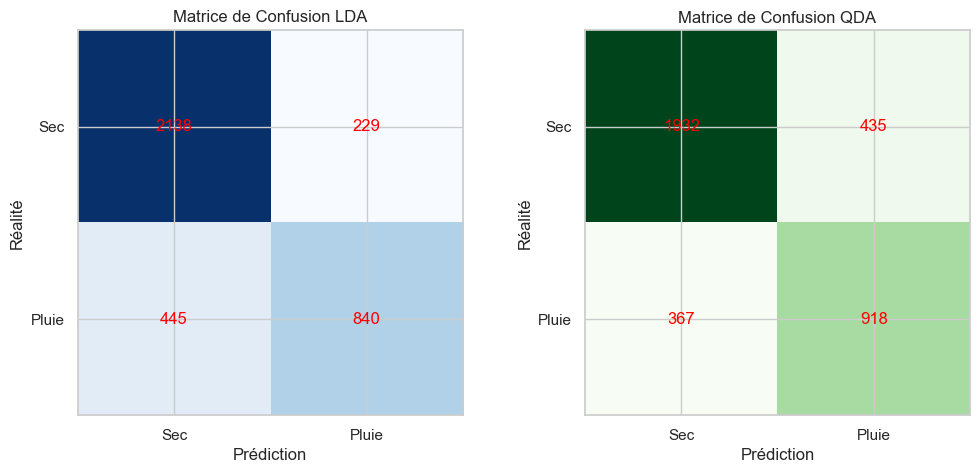

In [105]:
#On compare deux modèles : LDA et QDA
#LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)
y_prob_lda = lda.predict_proba(X_test_scaled)[:, 1] 

#QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)
y_prob_qda = qda.predict_proba(X_test_scaled)[:, 1] 
# Résultats
print("Rapport LDA :")
print(classification_report(y_test, y_pred_lda, target_names=['Sec', 'Pluie']))

print("Rapport QDA:")
print(classification_report(y_test, y_pred_qda, target_names=['Sec', 'Pluie']))

#Confusion matrix
cm_lda = confusion_matrix(y_test, y_pred_lda)
cm_qda = confusion_matrix(y_test, y_pred_qda)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# LDA
axes[0].imshow(cm_lda, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Matrice de Confusion LDA')
axes[0].set_xlabel('Prédiction')
axes[0].set_ylabel('Réalité')
axes[0].set_xticks([0, 1]); axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Sec', 'Pluie']); axes[0].set_yticklabels(['Sec', 'Pluie'])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm_lda[i, j], ha="center", va="center", color="red")

# QDA
axes[1].imshow(cm_qda, interpolation='nearest', cmap=plt.cm.Greens)
axes[1].set_title('Matrice de Confusion QDA')
axes[1].set_xlabel('Prédiction')
axes[1].set_ylabel('Réalité')
axes[1].set_xticks([0, 1]); axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Sec', 'Pluie']); axes[1].set_yticklabels(['Sec', 'Pluie'])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, cm_qda[i, j], ha="center", va="center", color="red")

plt.show()

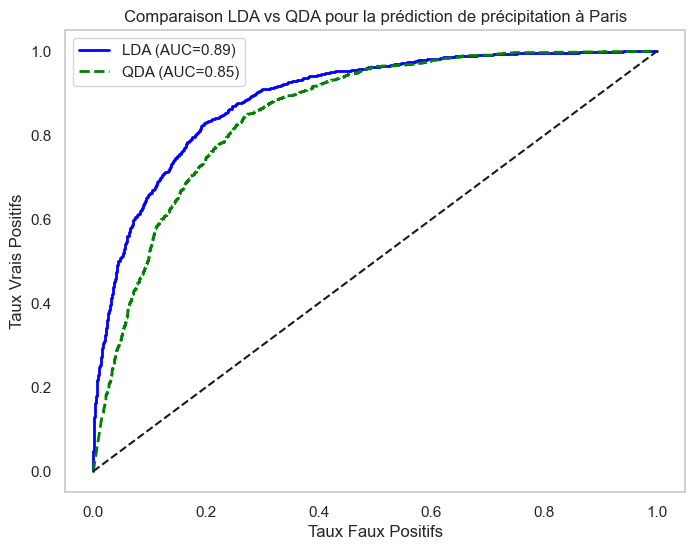

In [106]:
# Courbes ROC
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)

fpr_qda, tpr_qda, _ = roc_curve(y_test, y_prob_qda)
roc_auc_qda = auc(fpr_qda, tpr_qda)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lda,tpr_lda, label=f'LDA (AUC={roc_auc_lda:.2f})', color='blue', linewidth=2)
plt.plot(fpr_qda,tpr_qda, label=f'QDA (AUC={roc_auc_qda:.2f})', color='green', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('Taux Faux Positifs')
plt.ylabel('Taux Vrais Positifs')
plt.title('Comparaison LDA vs QDA pour la prédiction de précipitation à Paris')
plt.legend(loc = 'best')
plt.grid()
plt.show()

L'approche de classification binaire ("Pluie" / "Sec") sur des données journalières agrégées a permis de contourner les limites de la régression linéaire observées précédemment. 

Les deux modèles affichent une performance globale satisfaisante:
- LDA : Précision globale de 81%
- QDA : Précision globale de 79%

La LDA est légèrement supérieure en précision brute, mais l'analyse détaillée des classes révèle des compromis.

Le critère le plus critique pour un modèle de prévision est selon nous la capacité de détection de la pluie. La LDA a un rappel de 0.61 pour la pluie. Elle ne détecte que 61% des jours de pluie réels. Elle rate souvent les épisodes pluvieux (Faux négatifs).  La QDA a un rappel de 0.70. Elle détecte 70\% des jours de pluie. Elle est nettement plus sensible et donc plus utile pour une alerte météo, même si elle fait plus de fausses alarmes. 

La LDA est plus précise (0.78 contre 0.70) quand elle prédit de la pluie. Si la LDA dit "il va pleuvoir", elle a raison 78% du temps, contre 70% pour la QDA.

Les graphiques montrent la répartition des erreurs : 
- La LDA minimise les fausses alarmes (prédire "Pluie" alors qu'il fait "Sec"). C'est un modèle robuste qui trace une frontière linéaire simple.
- La QDA réussit à identifier plus de jours de pluie (Le rappel de 0.70 indique une meilleure détection).

Analyse des courbes ROC : l'aire sous la courbe de la LDA est plus élevée et la courbe de la LDA est presque systématiquement au dessus de la QDA, confirmant une supériorité globale

Pour conclure : 
- Si l'objectif est d'avoir un système d'alerte qui ne rate pas la pluie (minimiser les risques), la QDA est préférable grâce à son rappel de 70%.
- Si l'objectif est la fiabilité globale (éviter de dire n'importe quoi), la LDA est légèrement meilleure

Maintenant que nous avons établi un modèle de classification QDA capable de distinguer les jours de pluie des jours secs, l'objectif est de prédire la quantité de précipitations associée. Pour surmonter les difficultés rencontrées précédemment avec la régression simple, nous adoptons le Hurdle Model : le classifieur QDA agit comme un "portier" qui ne déclenche un régresseur spécialisé (Ridge) que si les conditions de pluie sont réunies.

On fait deux améliorations :
- La Transformation Logarithmique : La distribution des pluies étant exponentielle (disons 90% de petites averses, 9% de pluie modérée, 1% de gros orage), le passage au logarithme (log(1+x)) permet de ne pas aveugler le modèle par des orages

- L'intégration des lags à J-1 : En travaillant sur des données de la veille dans les autres villes agrégées à l'échelle journalière, nous permettons au modèle d'utiliser l'état de l'atmosphère d'hier pour mieux anticiper la pluie à Paris aujourd'hui, utile pour comprendre des mouvements de dépressions.

Moyenne: 1.96 mm/jour
Écart-type: 3.53 mm
Maximum : 34.11 mm
Médiane :0.34 mm
Jours Secs (<1.0mm)    : 9225 (63.1%)
Jours Pluvieux (>=1.0mm): 5384 (36.9%)
Asymétrie Données Brutes : 3.05 
Asymétrie après Log(1+x)   : 1.08


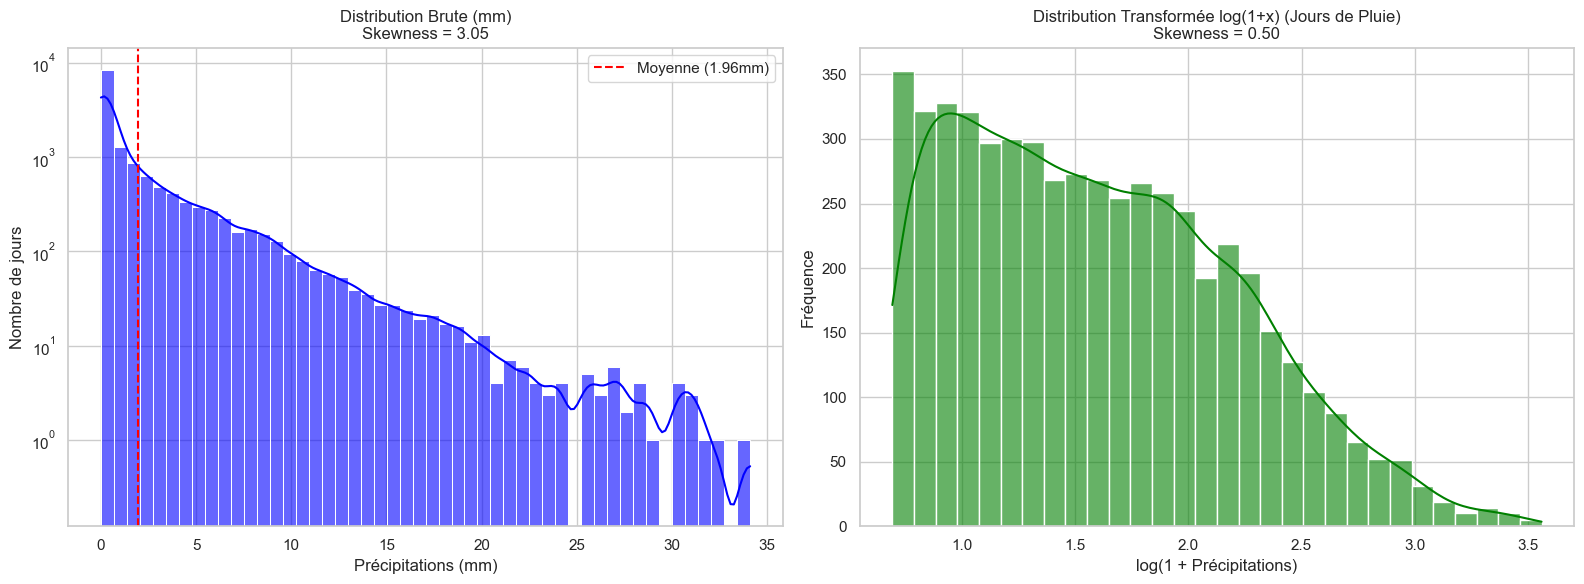

In [107]:
#Quelques statistiques sur les précipitations à Paris
rain_mm = df_daily["tp_paris"] * 1000

# Stats de base
desc = rain_mm.describe()
print(f"Moyenne: {desc['mean']:.2f} mm/jour")
print(f"Écart-type: {desc['std']:.2f} mm")
print(f"Maximum : {desc['max']:.2f} mm")
print(f"Médiane :{desc['50%']:.2f} mm")

# Analyse des Zéros
THRESHOLD = 1.0 
n_days = len(rain_mm)
n_dry = (rain_mm < THRESHOLD).sum()
n_wet = (rain_mm >= THRESHOLD).sum()

print(f"Jours Secs (<{THRESHOLD}mm)    : {n_dry} ({n_dry/n_days:.1%})")
print(f"Jours Pluvieux (>={THRESHOLD}mm): {n_wet} ({n_wet/n_days:.1%})")

# Analyse de l'Asymétrie 
skew_raw = rain_mm.skew()
skew_log = np.log(rain_mm +1).skew()  

print(f"Asymétrie Données Brutes : {skew_raw:.2f} ")
print(f"Asymétrie après Log(1+x)   : {skew_log:.2f}")



fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution Brute
sns.histplot(rain_mm, bins=50, kde=True, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title(f"Distribution Brute (mm)\nSkewness = {skew_raw:.2f}")
axes[0].set_xlabel("Précipitations (mm)")
axes[0].set_ylabel("Nombre de jours")
axes[0].set_yscale('log') 
axes[0].axvline(rain_mm.mean(), color='red', linestyle='--', label=f'Moyenne ({rain_mm.mean():.2f}mm)')
axes[0].legend()

# On ne regarde que les jours de pluie 
rain_wet_only = rain_mm[rain_mm >= THRESHOLD]
rain_log = np.log1p(rain_wet_only)

sns.histplot(rain_log, bins=30, kde=True, ax=axes[1], color='green', alpha=0.6)
axes[1].set_title(f"Distribution Transformée log(1+x) (Jours de Pluie)\nSkewness = {rain_log.skew():.2f}")
axes[1].set_xlabel("log(1 + Précipitations)")
axes[1].set_ylabel("Fréquence")


plt.tight_layout()
plt.show()

 QDA : Résultats de la classification Pluie vs Sec :
Matrice de Confusion QDA :
[[1841  526]
 [ 520  765]]
Meilleur Alpha Ridge : 112.88
RMSE FINAL (2010+) : 3.50 mm/jour
R² Final (2010+) : 0.045


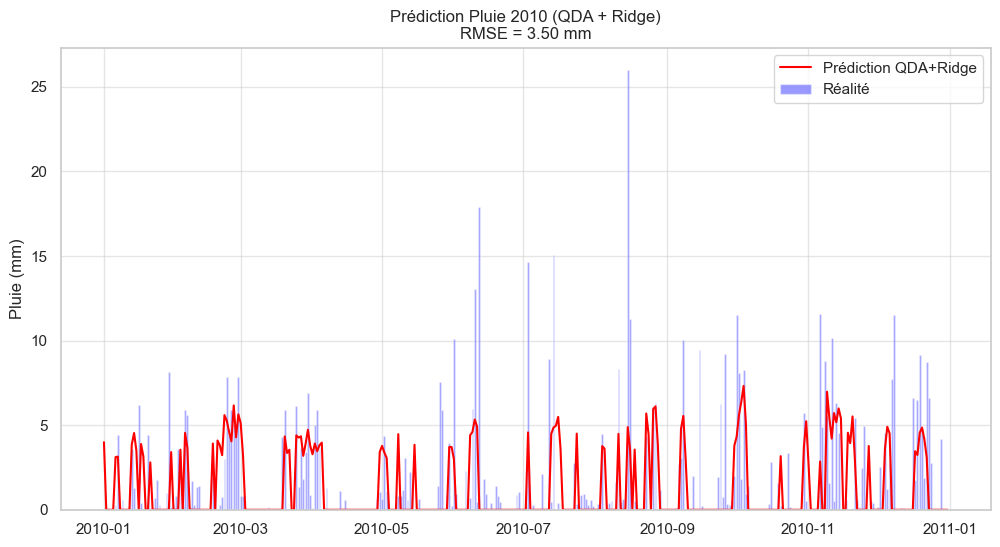

In [108]:


tp_cols = [c for c in df_all.columns if c.startswith('tp')]
other_cols = [c for c in df_all.columns if not c.startswith('tp')]

agg_dict = {c: 'sum' for c in tp_cols}     # Pluie = Somme
agg_dict.update({c: 'mean' for c in other_cols}) 
df_daily = df_all.resample('D').agg(agg_dict)

# On introduit des lags. 
target_col = "tp_paris"
df_model = pd.DataFrame()
# On prend toutes les variables sauf Paris
feature_cols = [c for c in df_daily.columns if not c.endswith('paris')]
for col in feature_cols:
    df_model[f"{col}_lag1"] = df_daily[col].shift(1)


y_amount = df_daily[target_col] * 1000 
# Classification (Seuil 1mm)
PRECIP_THRESHOLD = 1.0
y_class = (y_amount >= PRECIP_THRESHOLD).astype(int)
# Log pour le ridge
y_log =np.log(y_amount + 1)  

valid_indices = df_model.dropna().index
X = df_model.loc[valid_indices]
y_amount = y_amount.loc[valid_indices]
y_class = y_class.loc[valid_indices]
y_log = y_log.loc[valid_indices] 


split_date = "2010-01-01"

X_train = X.loc[X.index < split_date]
X_test = X.loc[X.index >= split_date]

y_train_cls = y_class.loc[y_class.index < split_date] 
y_train_log = y_log.loc[y_log.index < split_date] 

y_test_cls = y_class.loc[y_class.index >= split_date] 
y_test_amt = y_amount.loc[y_amount.index >= split_date]

#Scaling 
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_sc, y_train_cls)


y_pred_class = qda.predict(X_test_sc) # Prédiction classe

#Résultats QDA
print(" QDA : Résultats de la classification Pluie vs Sec :")
cm = confusion_matrix(y_test_cls, y_pred_class)
print("Matrice de Confusion QDA :")
print(cm)



# On entraîne le Ridge UNIQUEMENT sur les jours où il a plu (Train)
mask_wet_train = y_train_cls == 1 
X_train_wet = X_train_sc[mask_wet_train] 
y_train_log_wet = y_train_log[mask_wet_train]

# RidgeCV trouve le meilleur Alpha 
ridge_step2 = RidgeCV(alphas=np.logspace(-2, 5, 20), cv=5)
ridge_step2.fit(X_train_wet, y_train_log_wet)
print(f"Meilleur Alpha Ridge : {ridge_step2.alpha_:.2f}")

# Prédiction de ridge en log sur le test
y_pred_log_potential = ridge_step2.predict(X_test_sc)

y_pred_amt_potential = np.exp(y_pred_log_potential) - 1
# On s'assure qu'il n'y a pas de valeurs négatives
y_pred_amt_potential = np.maximum(y_pred_amt_potential, 0)

# Si QDA = 0 -> pas de pluie. Sinon -> Pluie = Ridge
y_pred_final = y_pred_class * y_pred_amt_potential

# RMSE Global
rmse_final = np.sqrt(mean_squared_error(y_test_amt, y_pred_final))
print(f"RMSE FINAL (2010+) : {rmse_final:.2f} mm/jour")
r2_final = r2_score(y_test_amt, y_pred_final)
print(f"R² Final (2010+) : {r2_final:.3f}")


# Graphique
plt.figure(figsize=(12, 6))

# Zoom sur 2010
dates_2010 = y_test_amt.loc['2010'].index
real_2010 = y_test_amt.loc['2010'] 
pred_2010 = pd.Series(y_pred_final, index=y_test_amt.index).loc['2010'] 
q_pred_2010 = pd.Series(y_pred_class, index=y_test_amt.index).loc['2010'] 

plt.bar(dates_2010, real_2010, color='blue', alpha=0.4, label='Réalité') 
plt.plot(dates_2010, pred_2010, color='red', linewidth=1.5, label='Prédiction QDA+Ridge')
plt.title(f"Prédiction Pluie 2010 (QDA + Ridge)\nRMSE = {rmse_final:.2f} mm")
plt.ylabel("Pluie (mm)")
plt.legend()
plt.grid(True, alpha=0.5)

Le score R² est vraiment mauvais. Il compare notre modèle à un modèle naif qui prédirait presque toujours la moyenne. La variance de la pluie est plutôt grande. Notre modèle réduit un peu cette variance car il met des zeros plus souvent au bon endroit. Mais il pêche lorsqu'il s'agit de prédire la bonne quantité de pluie sur les pics. Prédire 5mm au lieu de 15mm, c'est une mauvaise prédiction même si l'on va dans la bonne direction. 

Notre modèle nous dit globalement "parapluie" ou "pas parapluie" avec 70% de chance. Sans le lag, donc en prédisant la pluie à Paris en fonction de ce qu'il s'est passé dans les autres villes sur le jour même, nous pouvons faire tourner l'algorithme suivant :

 QDA : Résultats de la classification Pluie vs Sec :
Matrice de Confusion QDA :
[[1932  435]
 [ 367  918]]
Meilleur Alpha Ridge : 0.70
RMSE FINAL (2010+) : 2.98 mm/jour
R² Final (2010+) : 0.310


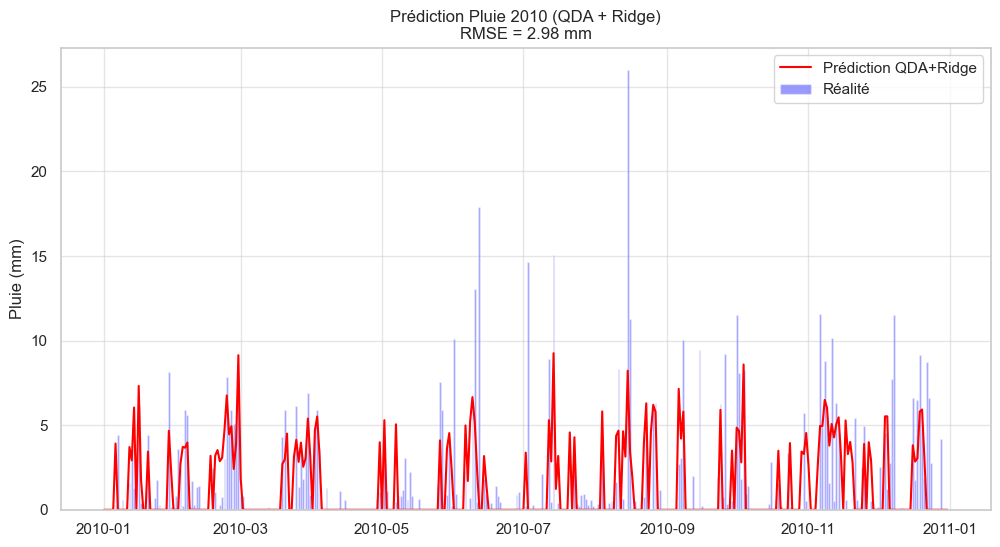

In [109]:

# Etape 1 : Préparation des données pour le modèle QDA + Ridge
tp_cols = [c for c in df_all.columns if c.startswith('tp')]
other_cols = [c for c in df_all.columns if not c.startswith('tp')]

agg_dict = {c: 'sum' for c in tp_cols}     # Pluie = Somme
agg_dict.update({c: 'mean' for c in other_cols}) # Le reste = Moyenne
df_daily = df_all.resample('D').agg(agg_dict)

target_col = "tp_paris"
df_model = pd.DataFrame()
# On prend toutes les variables sauf Paris
features_cols = [c for c in df_daily.columns if not c.endswith('paris')]
for col in features_cols:
    df_model[f"{col}_lag1"] = df_daily[col].shift(0)

y_amount = df_daily[target_col] * 1000 
# Classification (Seuil 1mm)
PRECIP_THRESHOLD = 1.0
y_class = (y_amount >= PRECIP_THRESHOLD).astype(int)
# Log pour le ridge
y_log =np.log(y_amount + 1)  


valid_indices = df_model.dropna().index
X = df_model.loc[valid_indices]
y_amount = y_amount.loc[valid_indices]
y_class = y_class.loc[valid_indices]
y_log = y_log.loc[valid_indices] 


split_date = "2010-01-01"

#séparation train et test
X_train = X.loc[X.index < split_date]
X_test = X.loc[X.index >= split_date]

# Cibles Train
y_train_cls = y_class.loc[y_class.index < split_date] 
y_train_log = y_log.loc[y_log.index < split_date] 

# Cibles Test
y_test_cls = y_class.loc[y_class.index >= split_date] 
y_test_amt = y_amount.loc[y_amount.index >= split_date]

#Scaling 
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


# Etape 2 : QDA pour classifier Pluie vs Sec
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_sc, y_train_cls)


y_pred_class = qda.predict(X_test_sc) # Prédiction classe

#Résultats QDA
print(" QDA : Résultats de la classification Pluie vs Sec :")
cm = confusion_matrix(y_test_cls, y_pred_class)
print("Matrice de Confusion QDA :")
print(cm)


# Etape 3 : entrainement ridge sur les jours de pluie uniquement

# On entraîne le Ridge UNIQUEMENT sur les jours où il a plu 
mask_wet_train = y_train_cls == 1 
X_train_wet = X_train_sc[mask_wet_train] 
y_train_log_wet = y_train_log[mask_wet_train]

# RidgeCV trouve le meilleur Alpha 
ridge_step2 = RidgeCV(alphas=np.logspace(-2, 5, 20), cv=5)
ridge_step2.fit(X_train_wet, y_train_log_wet)
print(f"Meilleur Alpha Ridge : {ridge_step2.alpha_:.2f}")

# Prédiction de ridge en log sur le test
y_pred_log_potential = ridge_step2.predict(X_test_sc)

y_pred_amt_potential = np.exp(y_pred_log_potential) - 1
# On s'assure qu'il n'y a pas de valeurs négatives
y_pred_amt_potential = np.maximum(y_pred_amt_potential, 0)


# Etape 4 : Assemblage des deux modèles
# Si QDA = 0 -> pas de pluie. Sinon -> Pluie = Ridge
y_pred_final = y_pred_class * y_pred_amt_potential

# RMSE Global
rmse_final = np.sqrt(mean_squared_error(y_test_amt, y_pred_final))
print(f"RMSE FINAL (2010+) : {rmse_final:.2f} mm/jour")
r2_final = r2_score(y_test_amt, y_pred_final)
print(f"R² Final (2010+) : {r2_final:.3f}")

# Graphique
plt.figure(figsize=(12, 6))

# Zoom sur 2010
dates_2010 = y_test_amt.loc['2010'].index
real_2010 = y_test_amt.loc['2010'] 
pred_2010 = pd.Series(y_pred_final, index=y_test_amt.index).loc['2010'] 
q_pred_2010 = pd.Series(y_pred_class, index=y_test_amt.index).loc['2010'] 

plt.bar(dates_2010, real_2010, color='blue', alpha=0.4, label='Réalité') 
plt.plot(dates_2010, pred_2010, color='red', linewidth=1.5, label='Prédiction QDA+Ridge')
plt.title(f"Prédiction Pluie 2010 (QDA + Ridge)\nRMSE = {rmse_final:.2f} mm")
plt.ylabel("Pluie (mm)")
plt.legend()
plt.grid(True, alpha=0.5)

On obtient un R² = 0.25. 